計算前
--最終結果--
ピクセル数：12×18
収束判定: True
計算回数: 14
収束画像


<ipython-input-20-c8375cae750b>:176: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  custom_cmap = plt.cm.get_cmap('coolwarm')


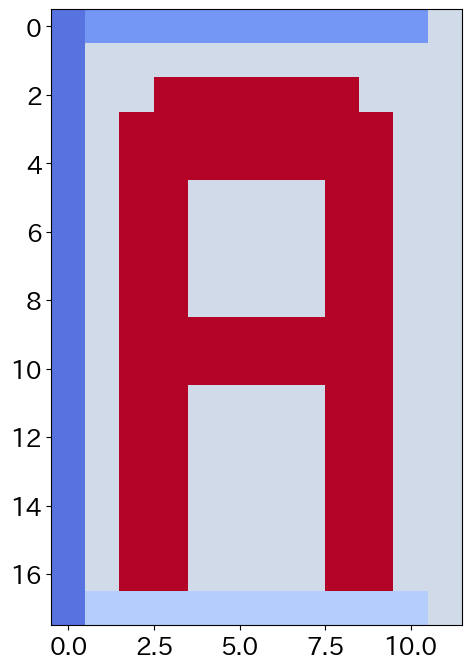

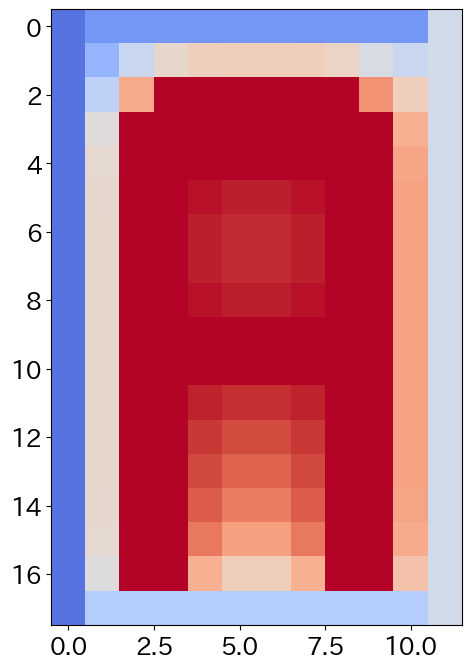

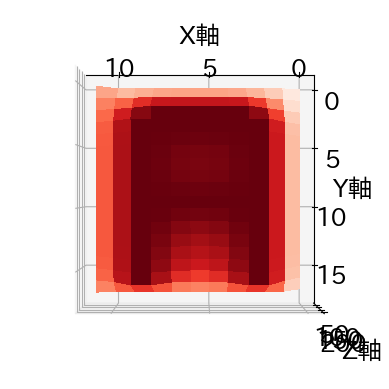

end


<Figure size 640x480 with 0 Axes>

In [20]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import japanize_matplotlib
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D
#ランダム
np.random.seed(0)

# 定数を生成
# 横軸の温度を生成
X_MAX = 100.0
X_MIN = 20.0

# 縦軸の温度を生成
Y_MAX = 40.0
Y_MIN = 80.0

#ランダム生成範囲:value_min <= ℃ <= value_max
value_min = 0.0
value_max = 220.0

# 材料の場所_温度[℃]
MATERIAL_LOCATION = 220.0
#収束条件[℃]
Convergence_condition = 0.01
#0.0000001:33


# 周囲に固定値を投入
def input_array(M,out_side_xmin, out_side_xmax, out_side_ymin, out_side_ymax):
    out_side_value = [out_side_xmin, out_side_xmax, out_side_ymin, out_side_ymax]
    x = 0
    y = 0
    z = 0
    x_range = len(M[0])  # X軸の長さ
    y_range = len(M)  # y軸の長さ
    # y軸移動で固定値を代入する処理
    while y < y_range:
        M[y][x] = out_side_value[z]
        y = y + 1
        if x != -1 and y == y_range:
            y = 0
            x = -1
            z = z + 1
        elif x == -1 and y == y_range:
            y = 0
            x = 1
            z = z + 1
            # x軸移動で固定値を代入する処理
            while x < x_range - 1:
                M[y][x] = out_side_value[z]
                x = x + 1
                if y != -1 and x == x_range - 1:
                    x = 1
                    y = -1
                    z = z + 1
                elif y == -1 and x == x_range - 1:
                    return M


# 二次元配列の生成
def create_2d_array(rows, columns, element):  # (y軸の個数,x軸の個数,配列内の数値)
    return [[element] * columns for _ in range(rows)]


#樹脂の有無をマーキングする
def Material_Marking(M,Mold_value):
    i = 0
    j = 0
    #横軸縦軸の数を合わせるために、同じ行列をコピー
    Mold_location =copy.deepcopy(M)
    #配列の要素内の場合:True
    while len(M) >= j and len(M[0]) >= i:

        #配列内に樹脂がある場合:Trueを代入
        if M[j][i] == Mold_value:
            Mold_location[j][i] = True
        #配列内に樹脂がない場合:Falseを代入
        else:
            Mold_location[j][i] = False
        i += 1
        #右端に付いたら左端に戻り一段下がる
        if i >= len(M[0]) - 1:
            i = 1
            j += 1
        #右下に付いたらBreak
        if  j >= len(M) - 1:
            break
    return Mold_location


# ランダム値を生成
def Array_Outer_Reference(M, y, x, start, end, threshold):
    while y != len(M):
        # 生成先に固定値がある場合
        if x == 0 and y == 0:
            x = 1
            y = 1

        # 生成先に素材がある場合
        if M[y][x] == threshold:
            x += 1
            continue
        #固定値および素材が存在しない場合
        elif x == len(M[0]):
            y += 1
            x = 1
        else:
            #ランダムな数値を入力
            #M[y][x] = np.random.randint(start, end + 1)
            #任意の値を決定
            M[y][x] = 100
            x += 1

        if x == len(M[0]) - 1:
            y += 1
            x = 1

        # 行列の右端なら処理修了
        if y >= len(M) - 1:
            break
    return M


# 温度計算
def Temp_Calculation(M, Y, X):
    if Y == 0 or X == 0:
        X = 1
        Y = 1

    # 十字計算
    a = M[Y][X + 1]
    b = M[Y][X - 1]
    c = M[Y + 1][X]
    d = M[Y - 1][X]

    # 計算結果の出力
    return (a + b + c + d) / 4


# 温度の収束判断
def Convergence_judg(M, W, j, i,Convergence_condition):
    i = 1
    j = 1
    msg = False
    # 比較する行列の大きさが異なる場合
    if len(M) != len(W) and len(M[0]) != len(W[0]):
        msg = "比較する行列の大きさが異なります"

    # 比較する行列の大きさが同じな場合
    else:
        #前回と今回の差が収束条件を満たしている場合、ループを続行
        if abs(M[j][i] - W[j][i]) < Convergence_condition:
            msg = True
            #print("True判定")
        #前回と今回の差が収束条件を満たしていない場合、ループを外れる
        elif abs(M[j][i] - W[j][i]) >= Convergence_condition:
            msg = False
            #print("False判定")
    return msg
#配列内に任意の値がどの位含まれているかを調べる
def count_values_above_threshold(array, threshold):
    count = 0
    for row in array:
        for value in row:
            if value >= threshold:
                count += 1
    return count

def ploter(M, title, xlabel='', ylabel='', figsizex=12, figsizey=8, fontsize=18, show_values=False, value_fontsize=12, value_color='white', vmin=value_min, vmax=value_max,save_fig=True):
    # NumPyの配列に変換
    data_array = np.array(M)

    # カスタムカラーマップの作成
    custom_cmap = plt.cm.get_cmap('coolwarm')

    # グラフのサイズを調整
    plt.figure(figsize=(figsizex, figsizey))
    plt.rcParams['font.size'] = fontsize

    # imshowを使ってグラフを描画し、カラーマップと範囲を設定
    plt.imshow(data_array, cmap=custom_cmap, interpolation='nearest', vmin=vmin, vmax=vmax)

    # グラフの各セルに数値を表示
    if show_values:
        for i in range(data_array.shape[0]):
            for j in range(data_array.shape[1]):
                value = data_array[i, j]
                text = "{:.2f}".format(value)  # 表示する数値の書式を指定（小数点以下2桁まで）
                plt.text(j, i, text, ha='center', va='center', color=value_color, fontsize=value_fontsize,rotation=45)
def plot_3d_array(array_2d, elev=90, azim=90):
    # 3Dプロット用のデータを作成
    data_3d = np.array(array_2d)

    # 3Dプロットを作成
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y = np.meshgrid(np.arange(data_3d.shape[1]), np.arange(data_3d.shape[0]))

    # 値の大きさによって色を変化させるためのカラーマップを設定
    cmap = plt.get_cmap('Reds')

    # 3Dプロットを作成
    ls = LightSource(azdeg=45, altdeg=30)
    ax.plot_surface(x, y, data_3d, cmap=cmap, rstride=1, cstride=1, linewidth=0, antialiased=False, shade=False, norm=plt.Normalize(vmin=data_3d.min(), vmax=data_3d.max()), lightsource=ls)

    # 軸ラベルの設定
    ax.set_xlabel('X軸')
    ax.set_ylabel('Y軸')
    ax.set_zlabel('Z軸')

    # 視点を変更
    ax.view_init(elev=elev, azim=azim)

    # グラフを表示
    plt.show()
    plt.savefig('温度シミュレーション真上.png')
    #plt.save('3D_save_fig.png')


#メイン処理
A = MATERIAL_LOCATION
original_array =[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, A, A, A, A, A, A, 0, 0, 0],
                [0, 0, A, A, A, A, A, A, A, A, 0, 0],
                [0, 0, A, A, A, A, A, A, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, A, A, A, A, A, A, 0, 0],
                [0, 0, A, A, A, A, A, A, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
array_record = [0]*1000
# 行列の生成
Material_Maker = copy.deepcopy(Material_Marking(original_array,MATERIAL_LOCATION))

# 外側に固定値を代入
original_array = input_array(original_array, X_MIN, X_MAX, Y_MAX, Y_MIN)

# ランダム値を生成
original_array = (Array_Outer_Reference(original_array, 0, 0, value_min, value_max, MATERIAL_LOCATION))
dummy_array = copy.deepcopy(original_array)
array = copy.deepcopy(original_array)
#比較用の計算前のグラフを出力
print("計算前")
ploter(original_array,'initial temperature', vmin=value_min, vmax=value_max,save_fig=False)

i = 0
j = 0
msg = False
loop_count = 0
#loop_num = (len(array)-1)*(len(array[0])-1)*50*2
loop_num = 0
test_flg = 0
test_count = 0
judg_count = 0
c = 0

#メインループ
# 行が端に達していない場合
while msg != True:#loop_count < loop_num :#
    #loop_count += 1
    # 配列の外側が参照される場合
    if i == 0 or j == 0:
        i = 1
        j = 1
    # 素材を参照した場合とばす
    if Material_Maker[j][i]:
        i += 1
        continue
    # ダミーに計算結果を代入
    while j < len(array) -1:
        # 素材を参照した場合とばす
        if Material_Maker[j][i]:
            i += 1
            continue
        #温度計算
        dummy_array[j][i] = copy.deepcopy((Temp_Calculation(array, j, i)))

        i += 1
        # 行の端に達した場合、行を折り返し列をともに+1する。
        if i >= len(array[0])-1:
            i = 1
            j += 1
            test_flg = 1

    # 列の最後かつ、行の最後の場合
    if msg != True:
        loop_count += 1
        array_record[loop_count-1] = dummy_array
        #ploter(dummy_array,'calculation'+str(loop_count),save_fig=False)
        # ダミーともとの行列を比較、収束ならTrue
        msg = Convergence_judg(array, dummy_array,j,i,Convergence_condition)
        if msg == True:
            # 三次元配列を作成して、二次元配列を格納
            #array_record[loop_count] = np.array([dummy_array])
            array = copy.deepcopy(dummy_array)
            i = 1
            j = 1
            test_flg = 0
            #array_record[loop_count-1] = dummy_array
            break
        elif msg != True:
            array = copy.deepcopy(dummy_array)
            i = 1
            j = 1
            test_flg = 0

print("--最終結果--")
print("ピクセル数："+ str(len(dummy_array[0])) + '×' + str(len(dummy_array)))
print("収束判定:",msg)
print("計算回数:",loop_count)
print("収束画像")
ploter(dummy_array,'calculation'+str(loop_count),save_fig=True)
plot_3d_array(dummy_array)
print("end")


In [4]:
pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=4c2346ecd8ba71999e7dc6f0d94329665a81a2e444a2d8c48fcfc8b43c9a4934
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


計算前


<ipython-input-1-57edf2678f2b>:175: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  custom_cmap = plt.cm.get_cmap('coolwarm')


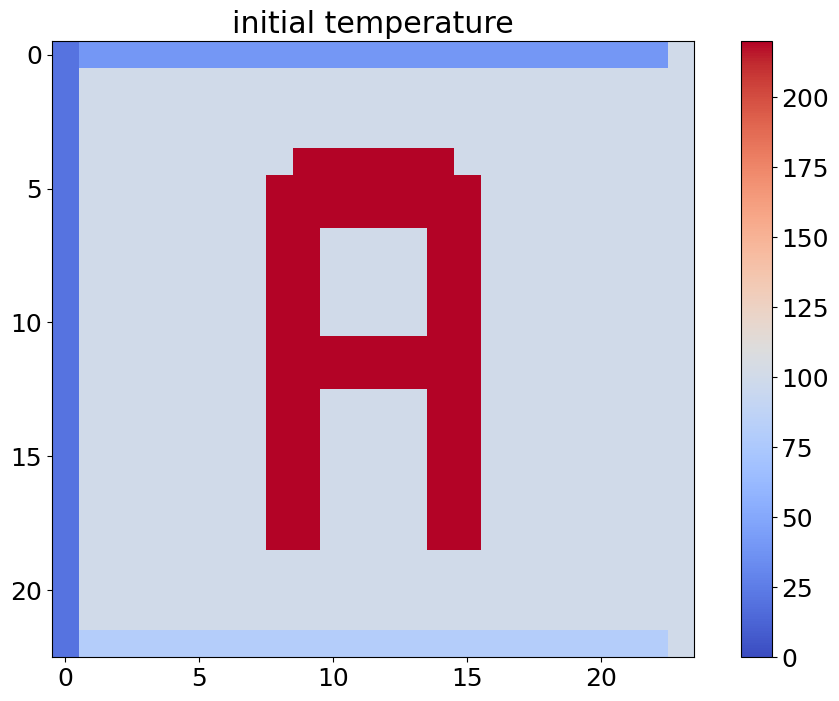

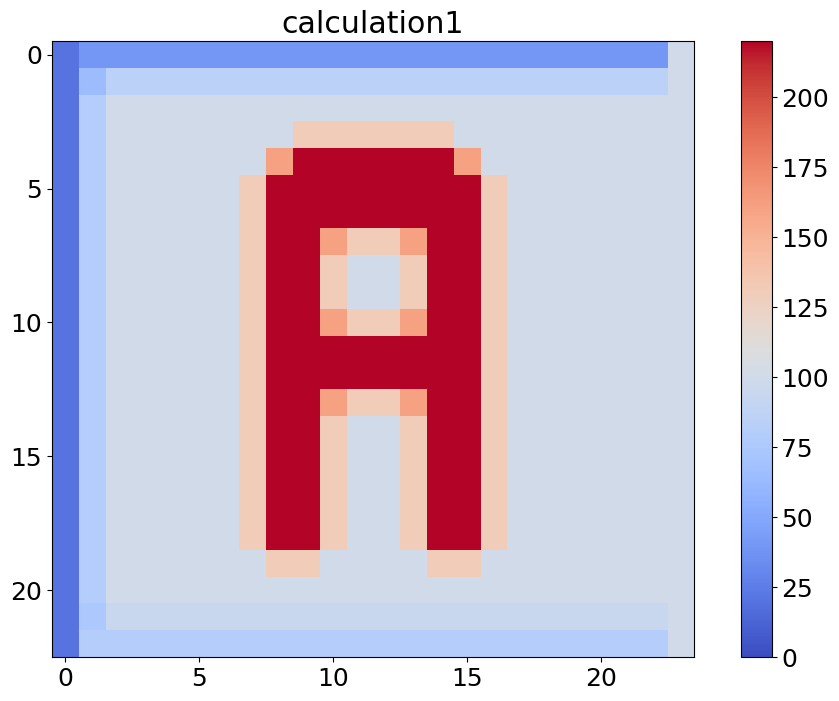

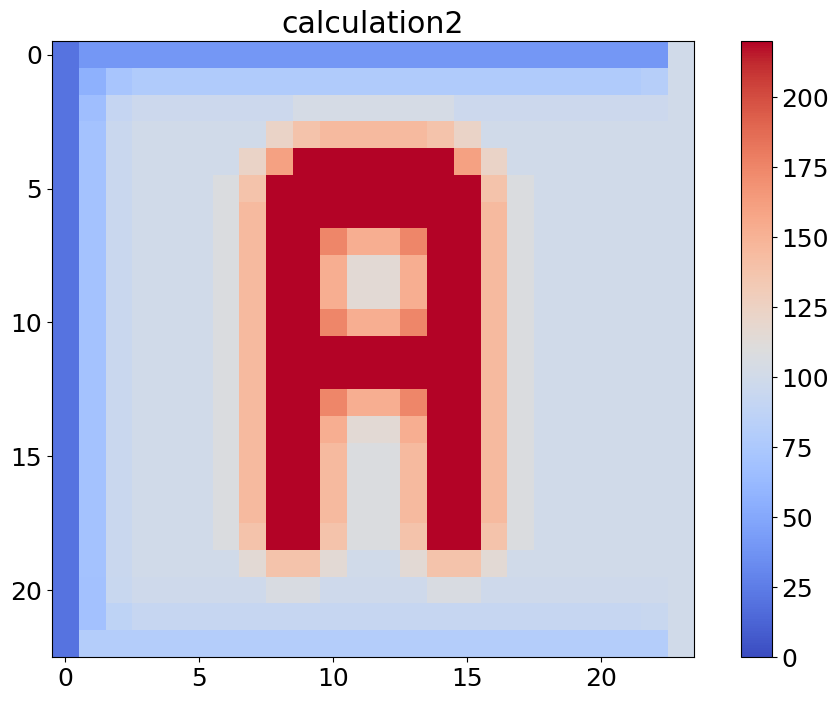

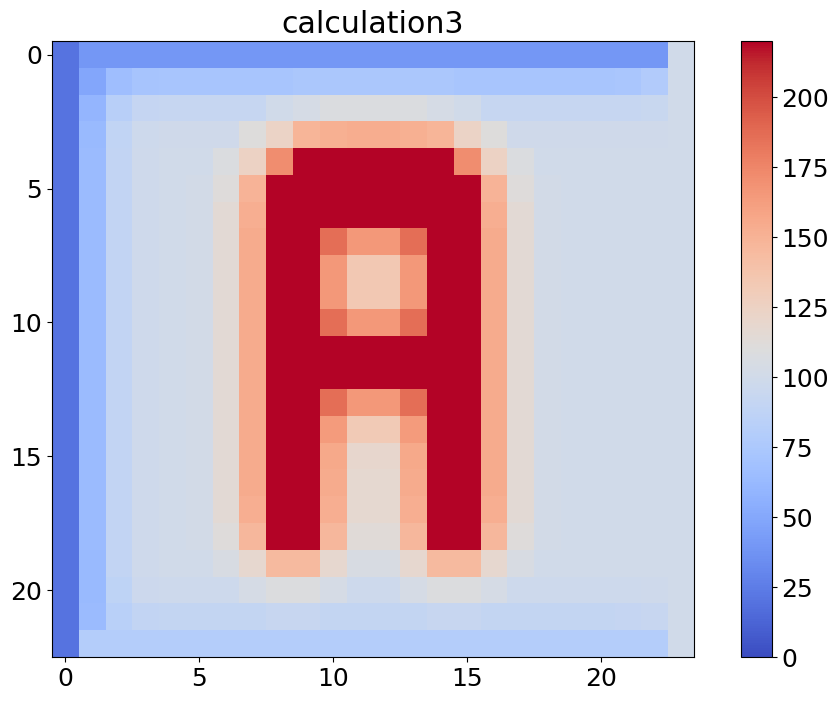

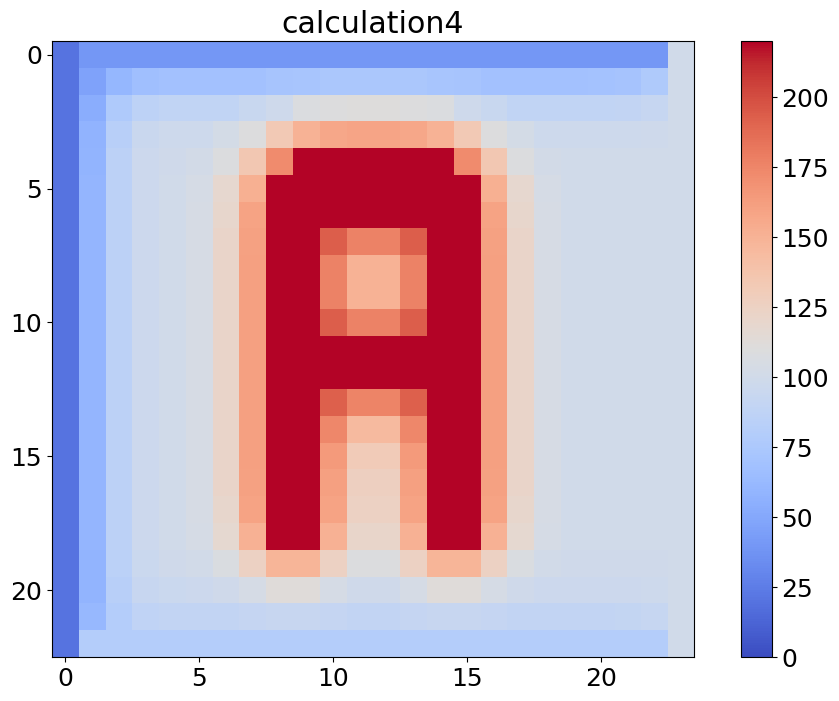

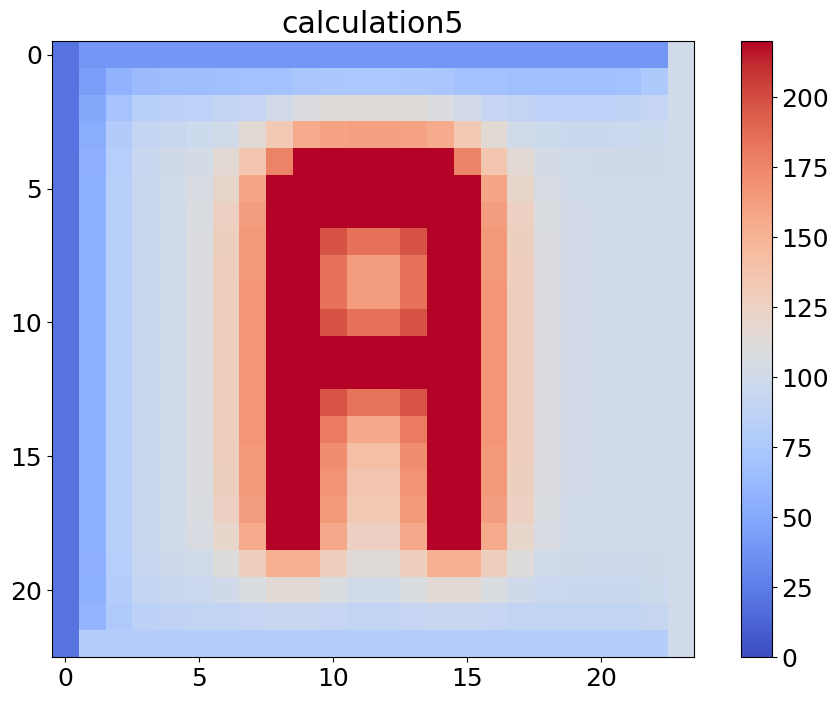

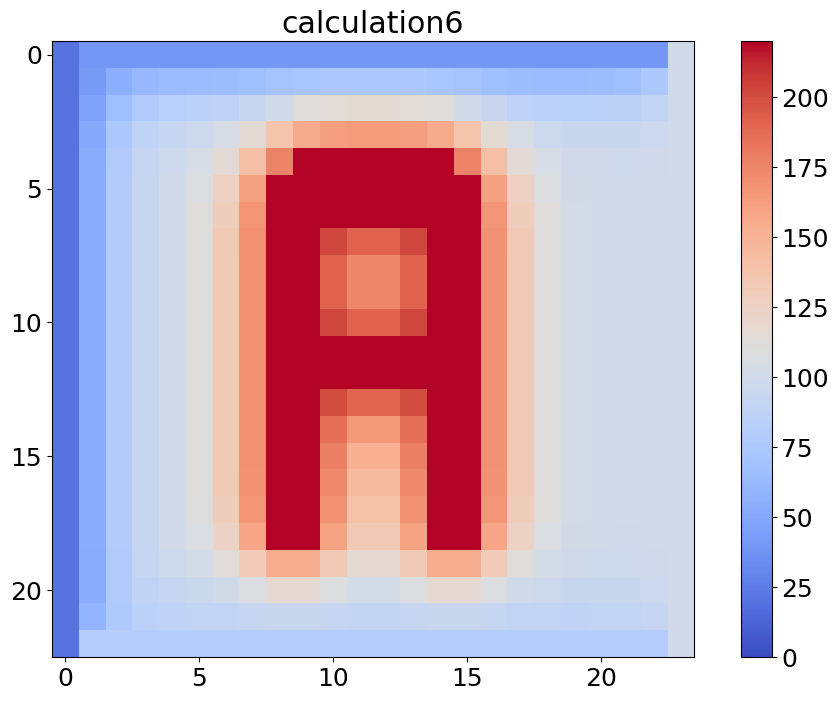

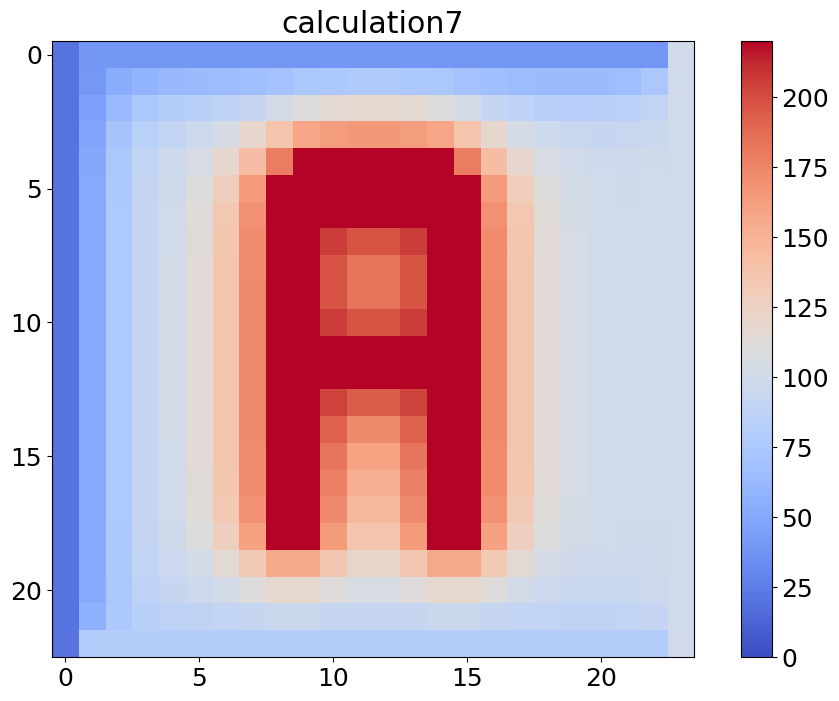

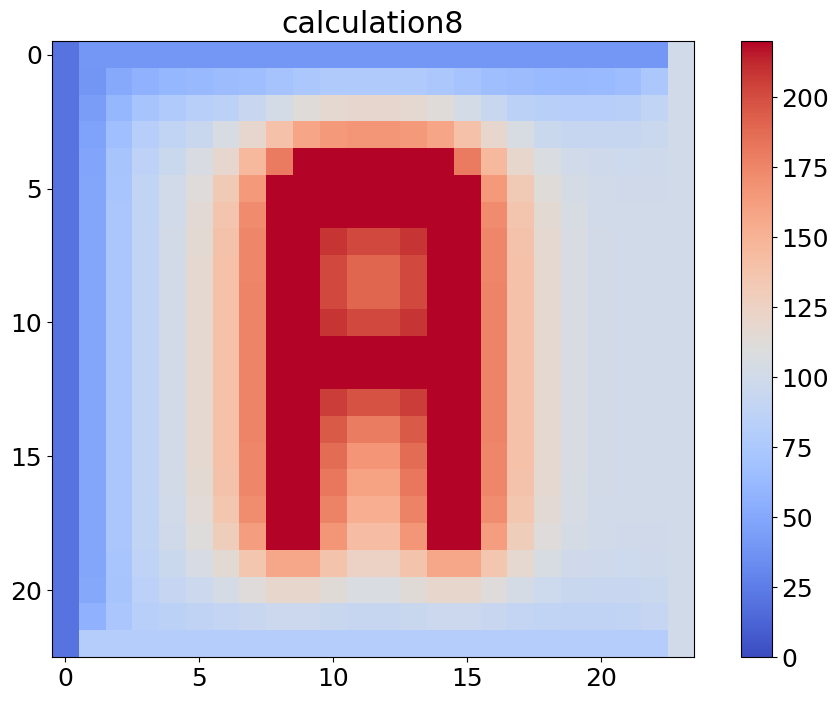

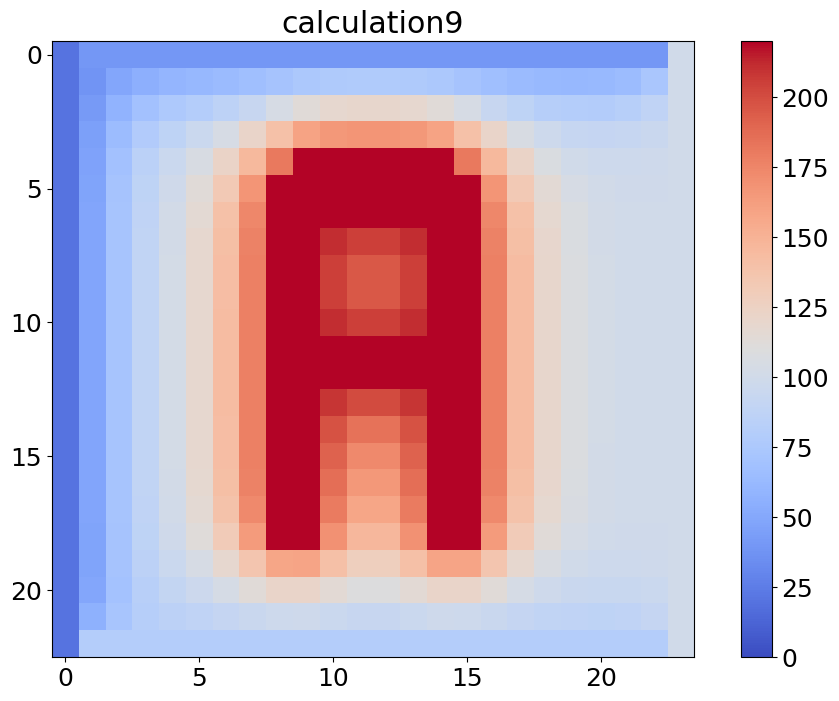

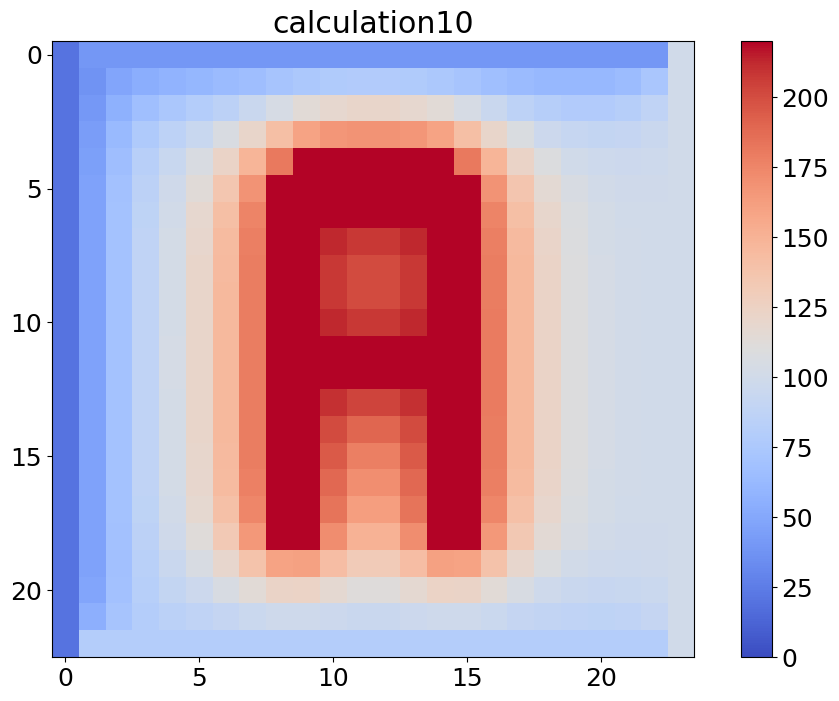

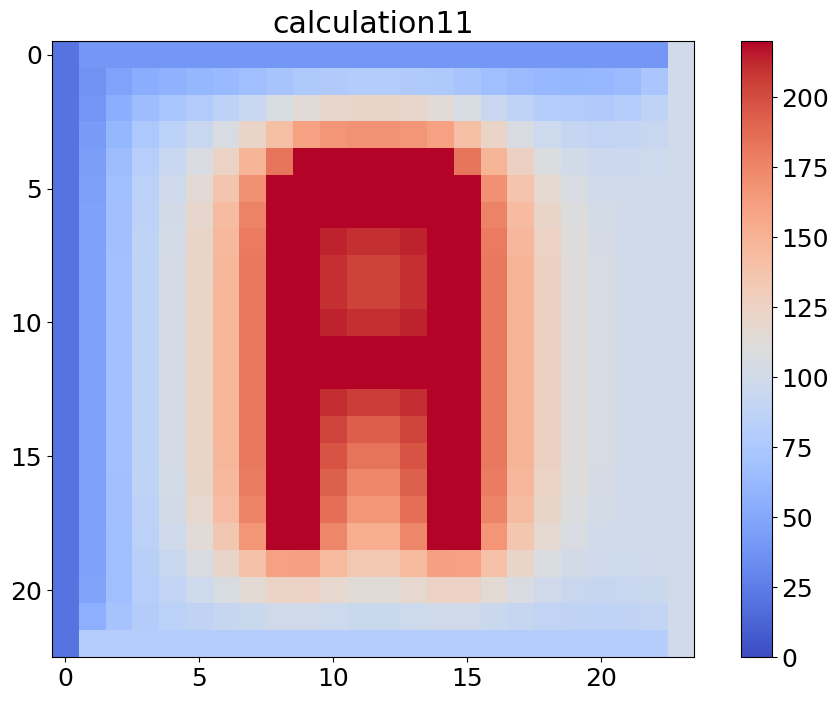

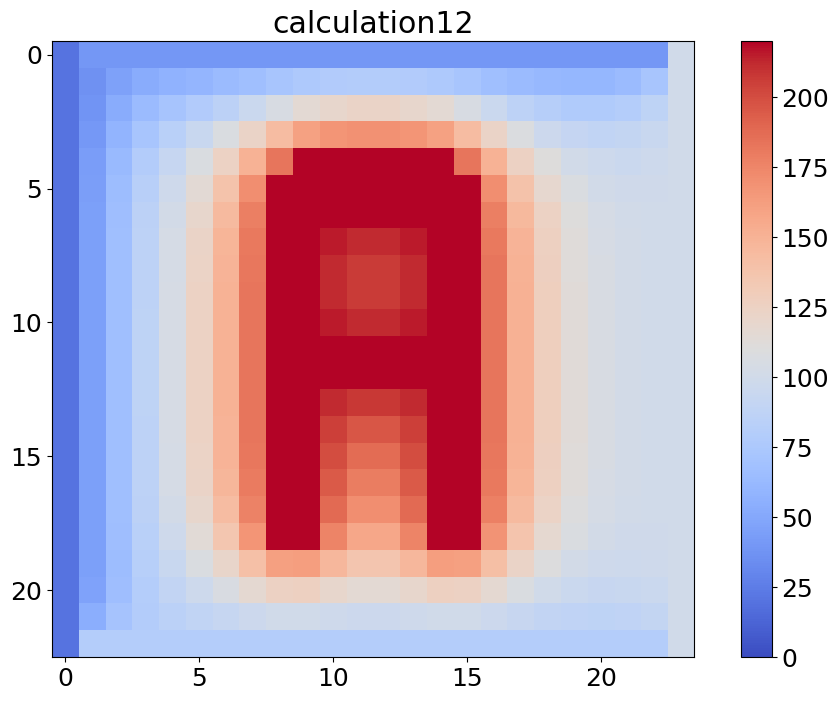

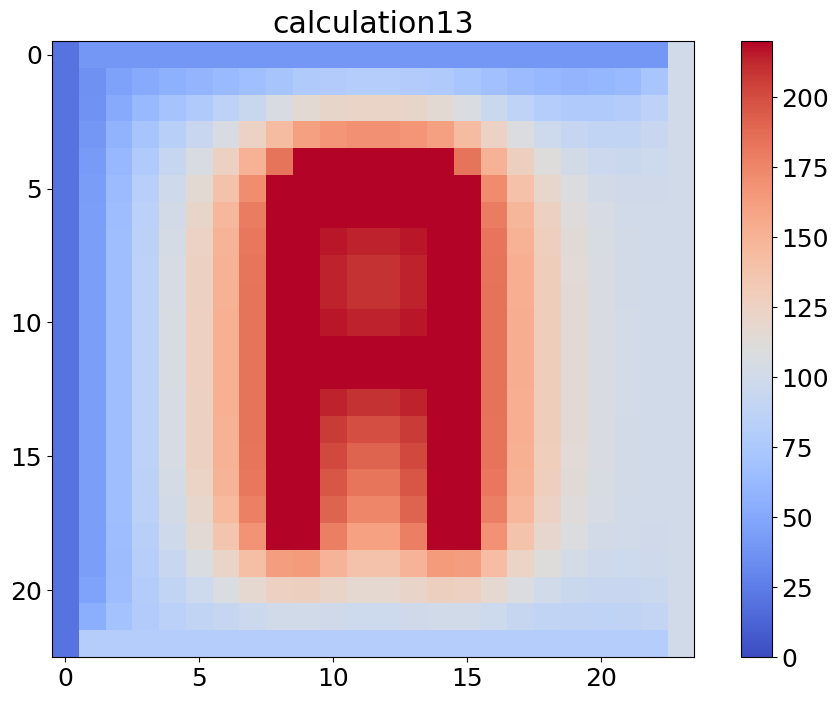

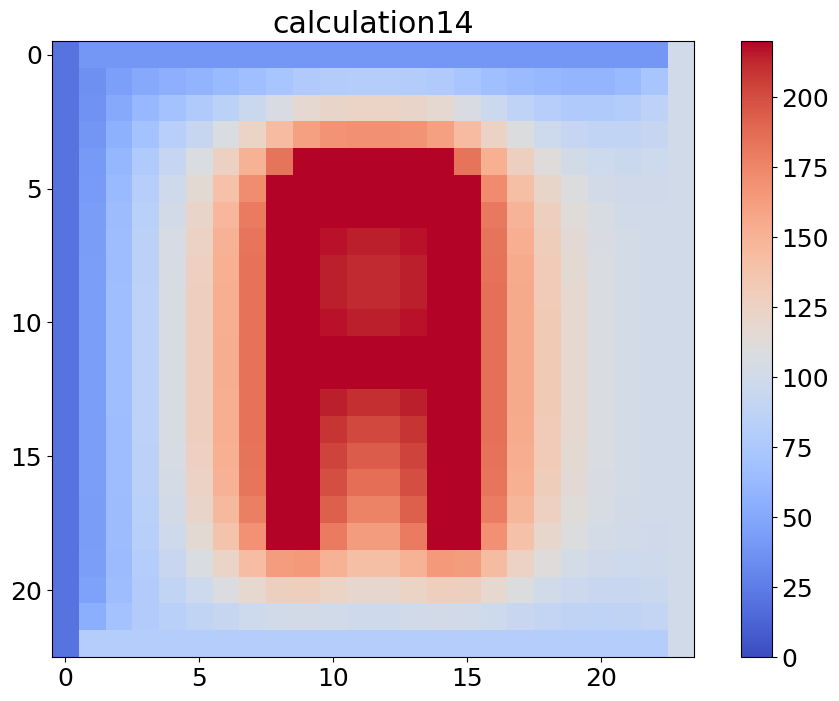

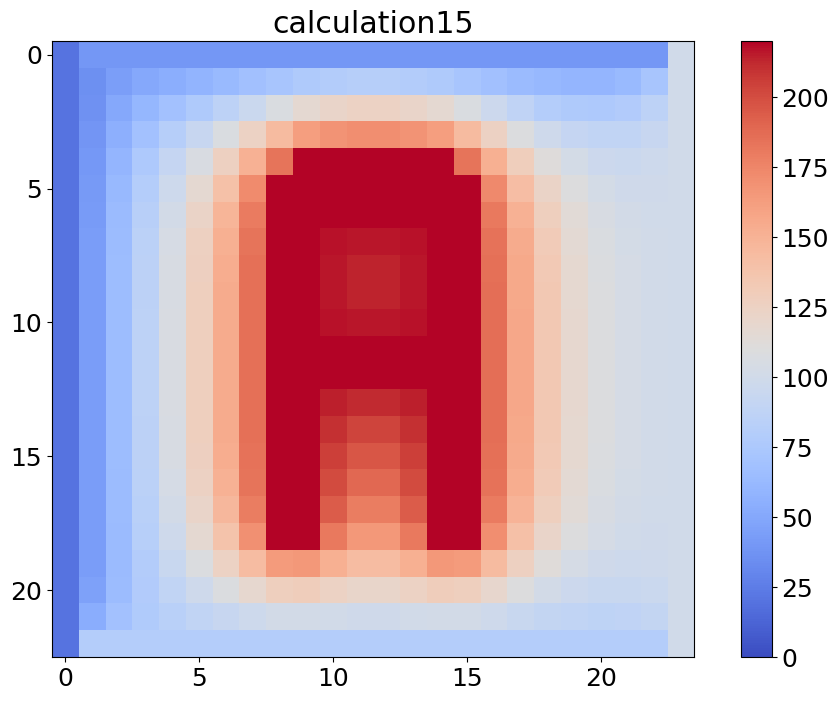

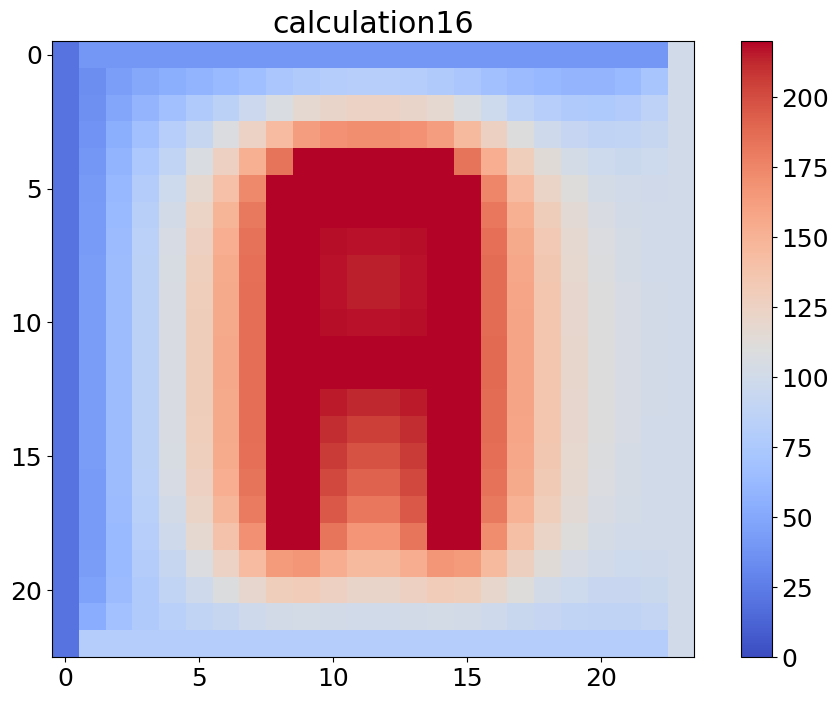

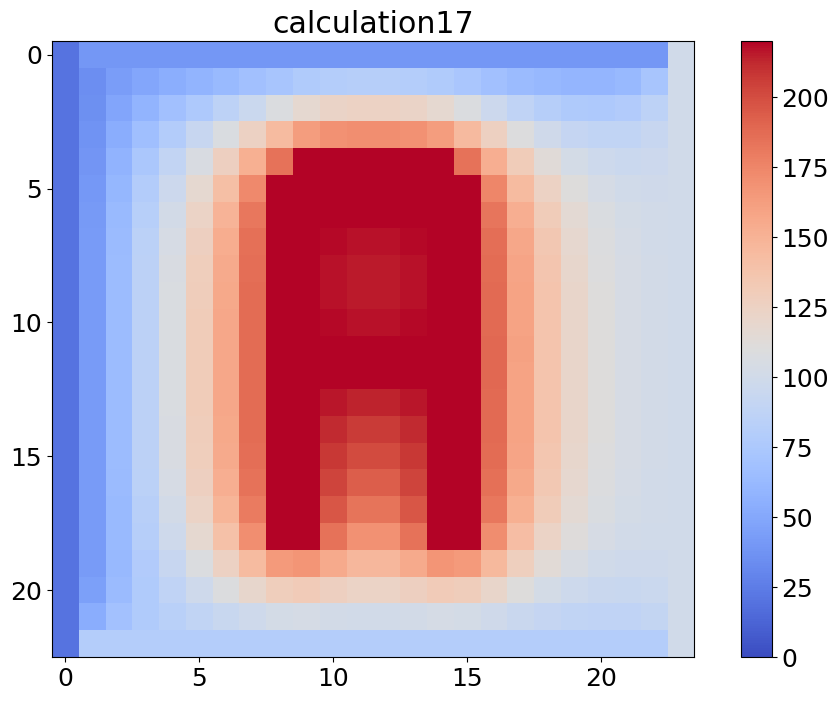

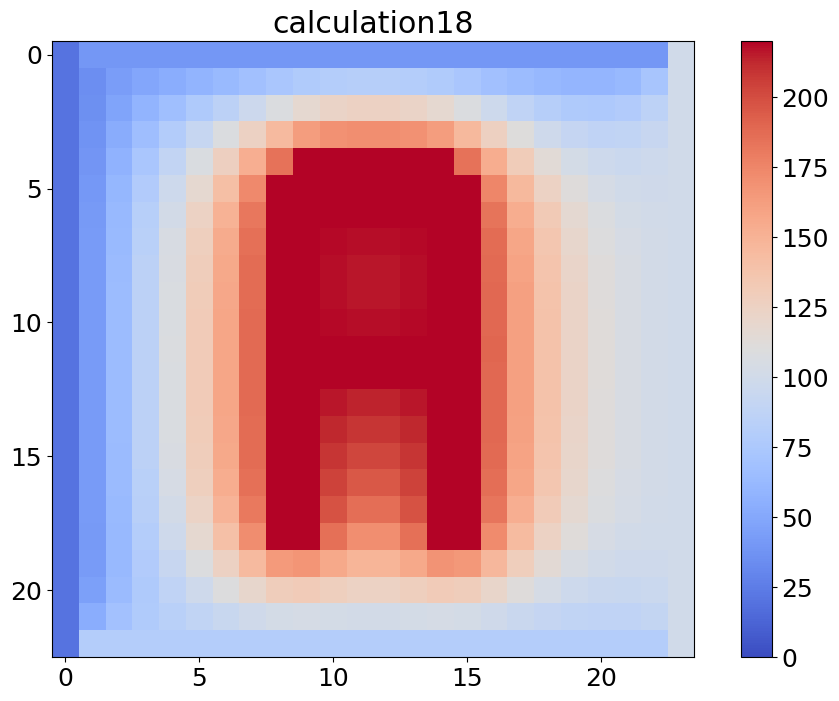

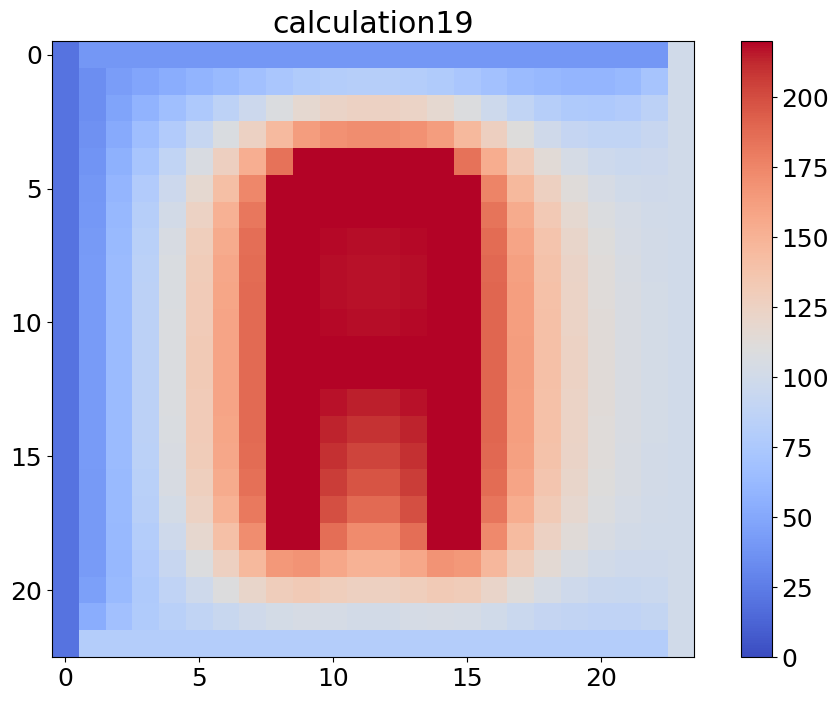

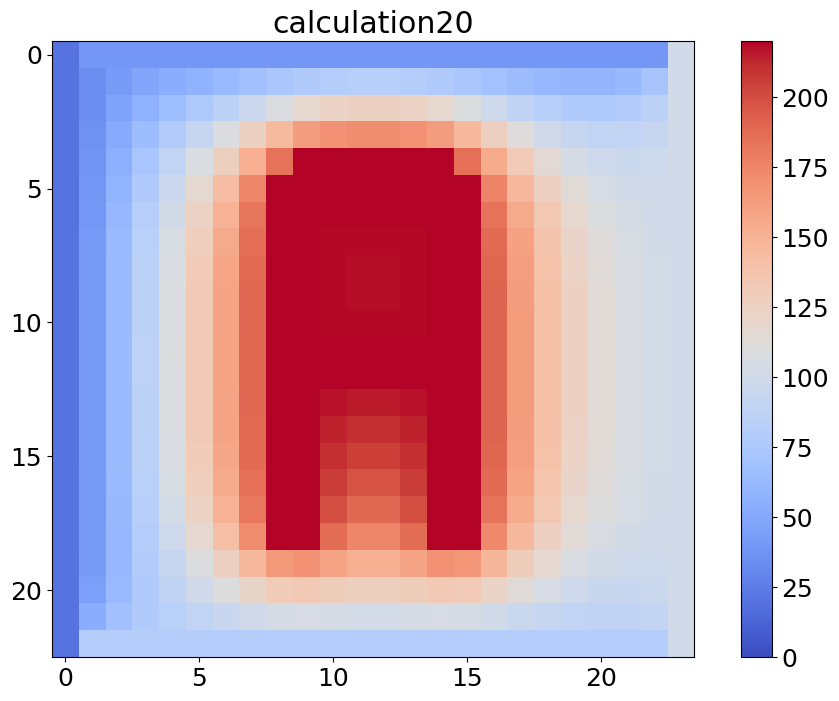

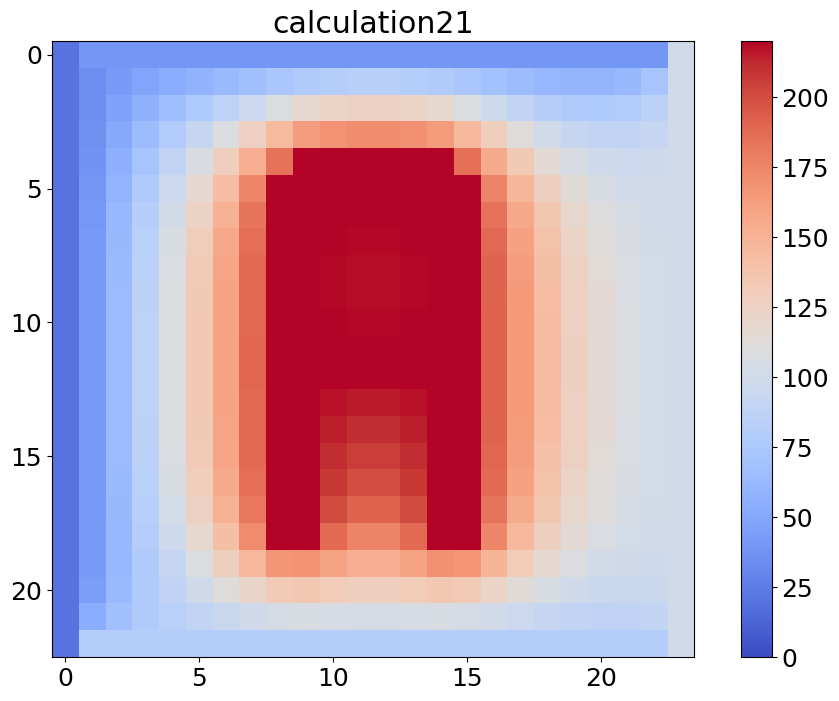

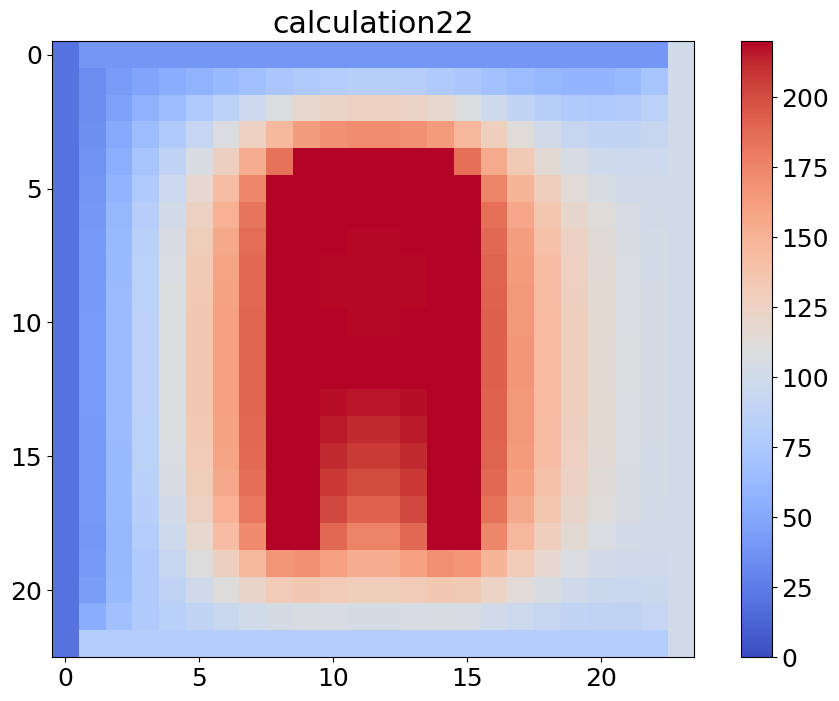

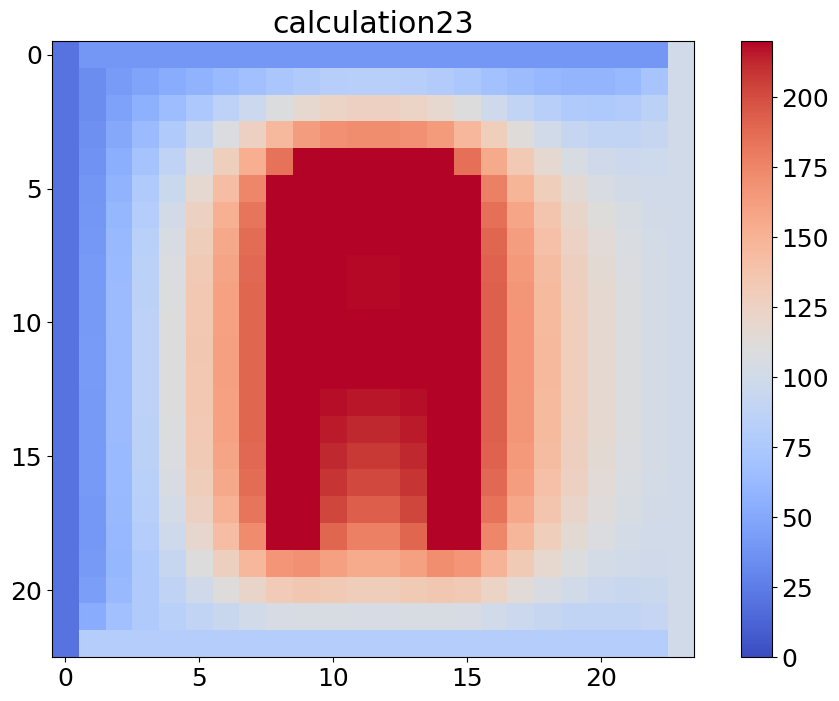

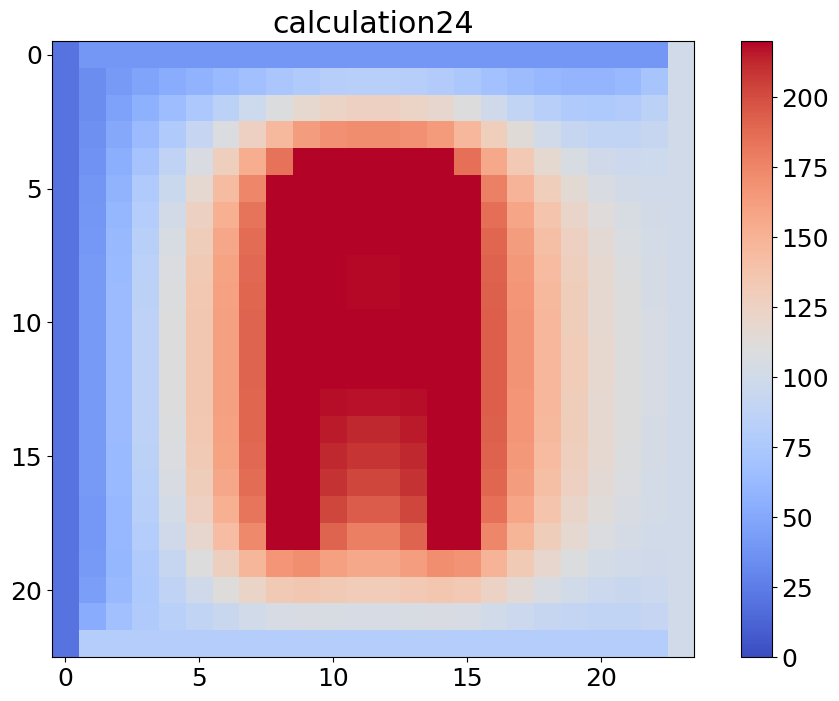

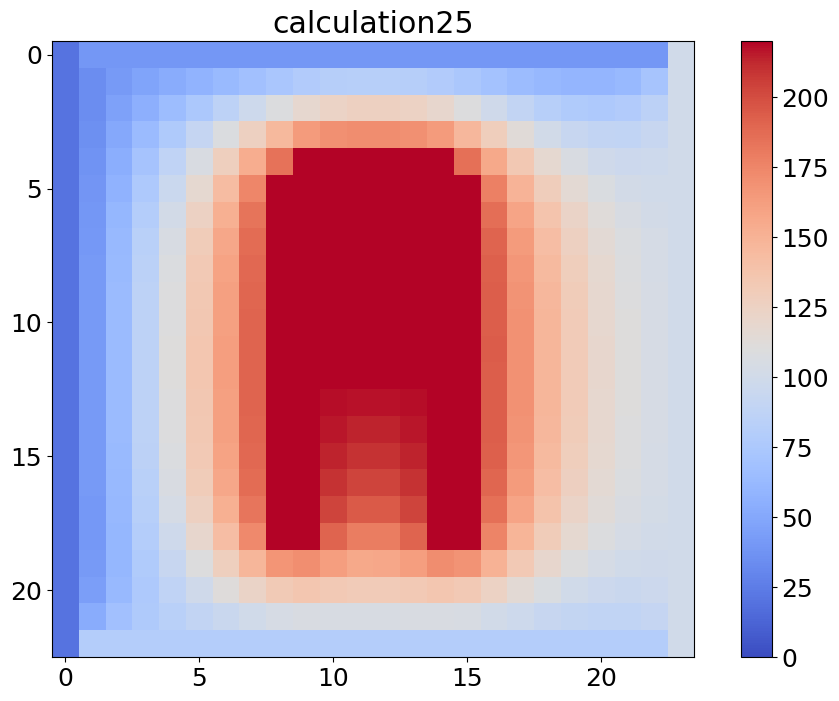

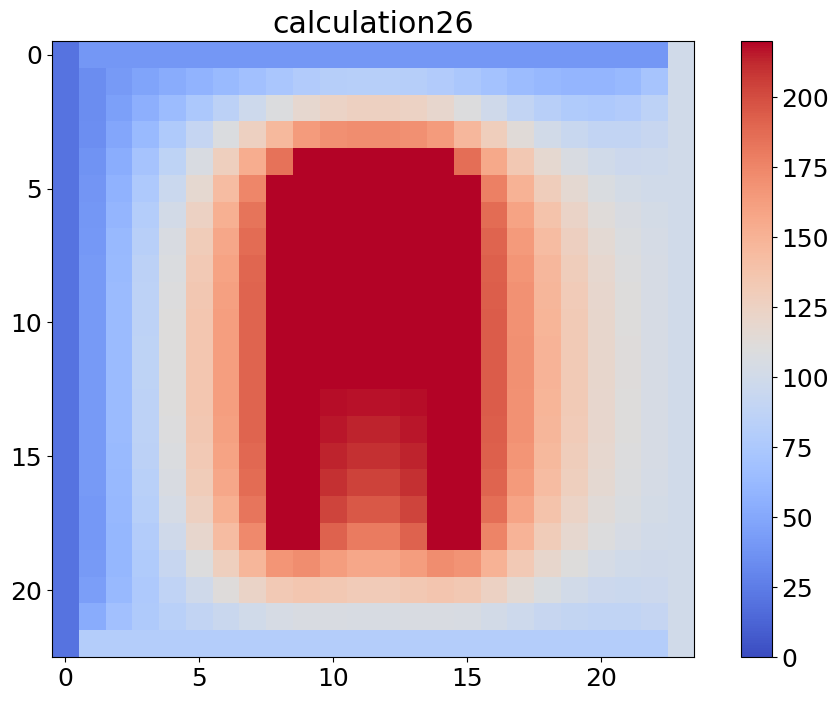

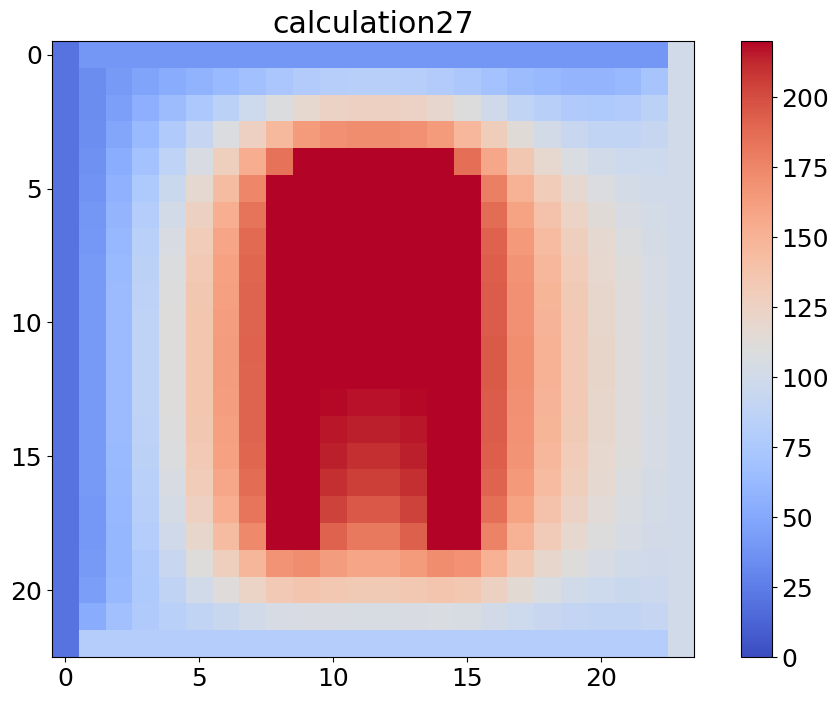

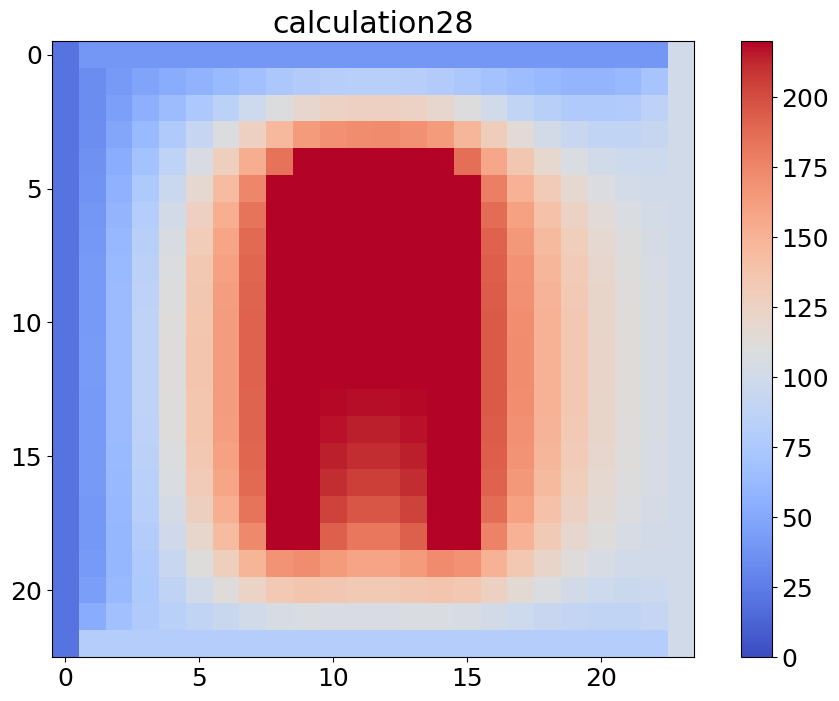

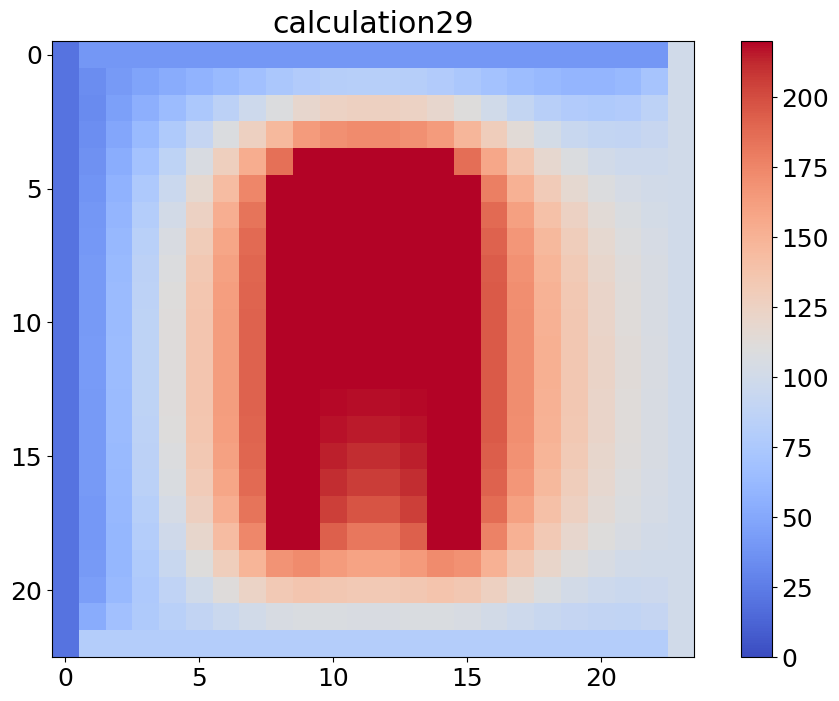

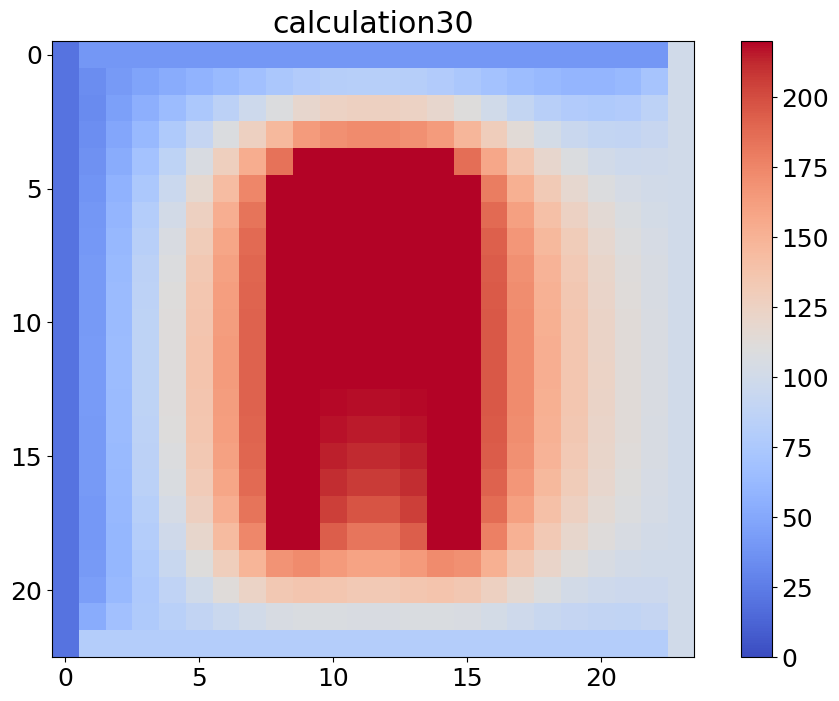

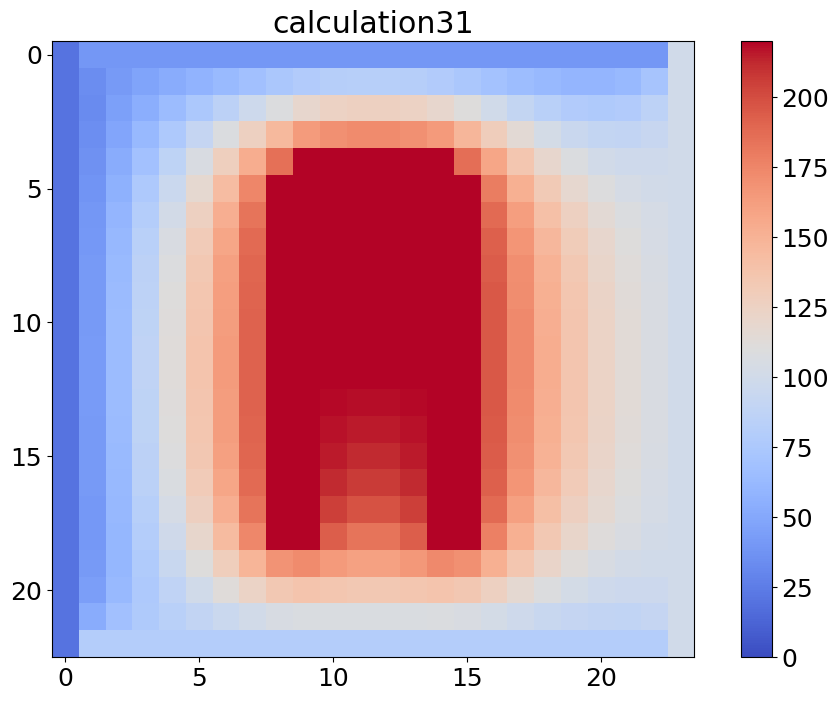

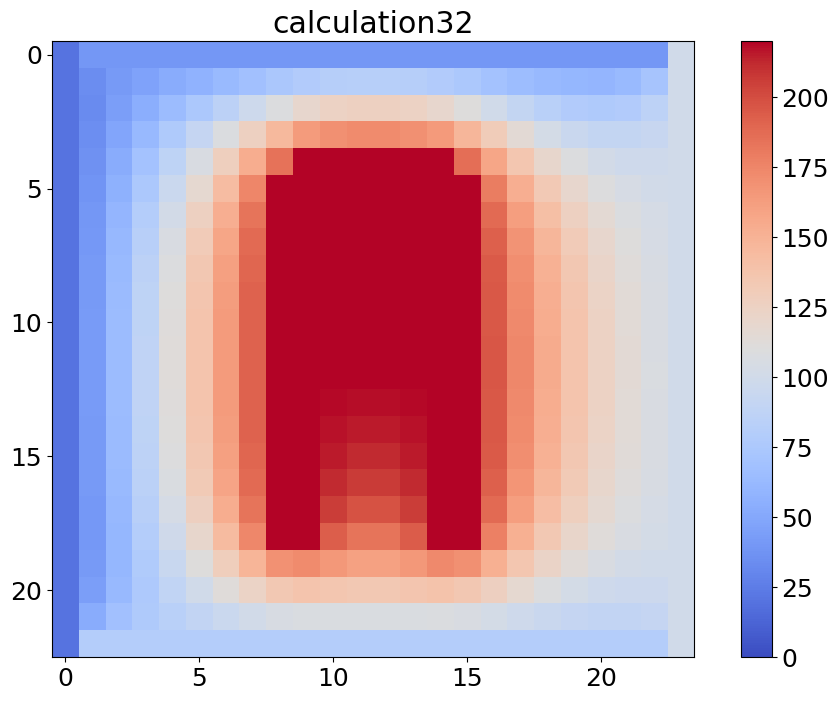

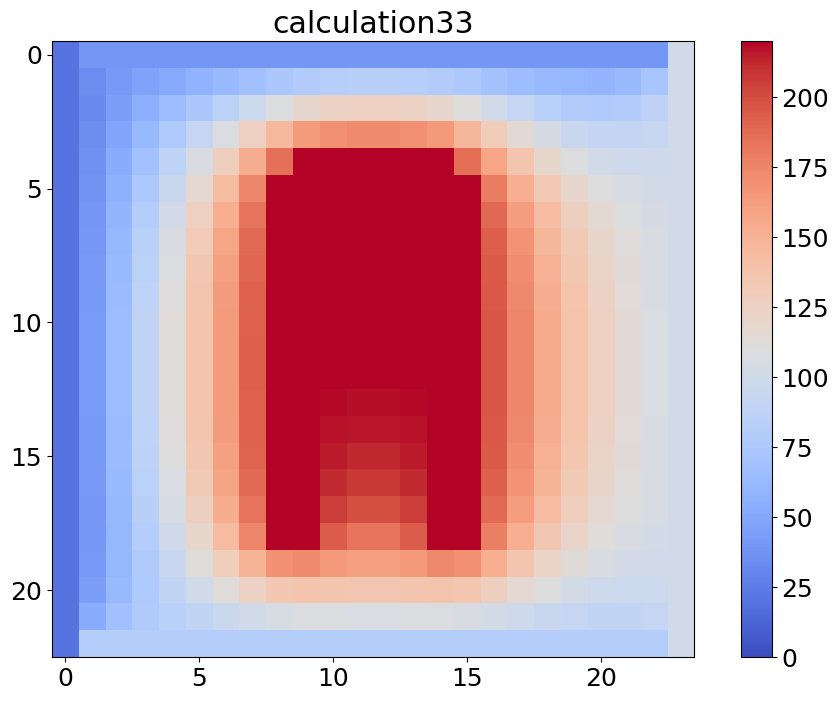

--最終結果--
ピクセル数：24×23
収束判定: True
計算回数: 33
収束画像


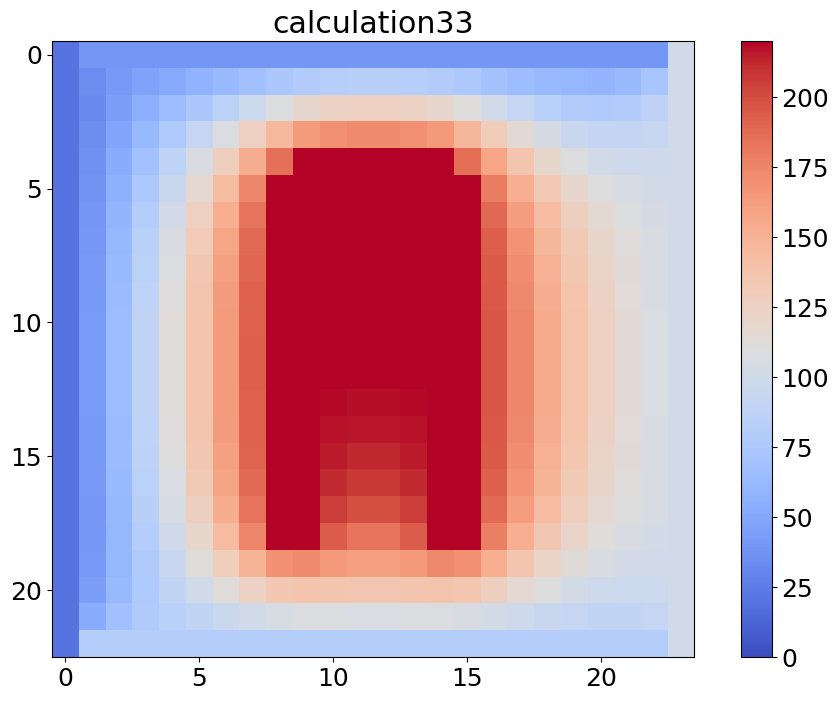

end


In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt
#import japanize_matplotlib

#ランダム
np.random.seed(0)

# 定数を生成
# 横軸の温度を生成
X_MAX = 100.0
X_MIN = 20.0

# 縦軸の温度を生成
Y_MAX = 40.0
Y_MIN = 80.0

#ランダム生成範囲:value_min <= ℃ <= value_max
value_min = 0.0
value_max = 220.0

# 材料の場所_温度[℃]
MATERIAL_LOCATION = 220.0
#収束条件[℃]
Convergence_condition = 0.01
#0.0000001:33


# 周囲に固定値を投入
def input_array(M,out_side_xmin, out_side_xmax, out_side_ymin, out_side_ymax):
    out_side_value = [out_side_xmin, out_side_xmax, out_side_ymin, out_side_ymax]
    x = 0
    y = 0
    z = 0
    x_range = len(M[0])  # X軸の長さ
    y_range = len(M)  # y軸の長さ
    # y軸移動で固定値を代入する処理
    while y < y_range:
        M[y][x] = out_side_value[z]
        y = y + 1
        if x != -1 and y == y_range:
            y = 0
            x = -1
            z = z + 1
        elif x == -1 and y == y_range:
            y = 0
            x = 1
            z = z + 1
            # x軸移動で固定値を代入する処理
            while x < x_range - 1:
                M[y][x] = out_side_value[z]
                x = x + 1
                if y != -1 and x == x_range - 1:
                    x = 1
                    y = -1
                    z = z + 1
                elif y == -1 and x == x_range - 1:
                    return M


# 二次元配列の生成
def create_2d_array(rows, columns, element):  # (y軸の個数,x軸の個数,配列内の数値)
    return [[element] * columns for _ in range(rows)]


#樹脂の有無をマーキングする
def Material_Marking(M,Mold_value):
    i = 0
    j = 0
    #横軸縦軸の数を合わせるために、同じ行列をコピー
    Mold_location =copy.deepcopy(M)
    #配列の要素内の場合:True
    while len(M) >= j and len(M[0]) >= i:

        #配列内に樹脂がある場合:Trueを代入
        if M[j][i] == Mold_value:
            Mold_location[j][i] = True
        #配列内に樹脂がない場合:Falseを代入
        else:
            Mold_location[j][i] = False
        i += 1
        #右端に付いたら左端に戻り一段下がる
        if i >= len(M[0]) - 1:
            i = 1
            j += 1
        #右下に付いたらBreak
        if  j >= len(M) - 1:
            break
    return Mold_location


# ランダム値を生成
def Array_Outer_Reference(M, y, x, start, end, threshold):
    while y != len(M):
        # 生成先に固定値がある場合
        if x == 0 and y == 0:
            x = 1
            y = 1

        # 生成先に素材がある場合
        if M[y][x] == threshold:
            x += 1
            continue
        #固定値および素材が存在しない場合
        elif x == len(M[0]):
            y += 1
            x = 1
        else:
            #ランダムな数値を入力
            #M[y][x] = np.random.randint(start, end + 1)
            #任意の値を決定
            M[y][x] = 100
            x += 1

        if x == len(M[0]) - 1:
            y += 1
            x = 1

        # 行列の右端なら処理修了
        if y >= len(M) - 1:
            break
    return M


# 温度計算
def Temp_Calculation(M, Y, X):
    if Y == 0 or X == 0:
        X = 1
        Y = 1

    # 十字計算
    a = M[Y][X + 1]
    b = M[Y][X - 1]
    c = M[Y + 1][X]
    d = M[Y - 1][X]

    # 計算結果の出力
    return (a + b + c + d) / 4


# 温度の収束判断
def Convergence_judg(M, W, j, i,Convergence_condition):
    i = 1
    j = 1
    msg = False
    # 比較する行列の大きさが異なる場合
    if len(M) != len(W) and len(M[0]) != len(W[0]):
        msg = "比較する行列の大きさが異なります"

    # 比較する行列の大きさが同じな場合
    else:
        #前回と今回の差が収束条件を満たしている場合、ループを続行
        if abs(M[j][i] - W[j][i]) < Convergence_condition:
            msg = True
            #print("True判定")
        #前回と今回の差が収束条件を満たしていない場合、ループを外れる
        elif abs(M[j][i] - W[j][i]) >= Convergence_condition:
            msg = False
            #print("False判定")
    return msg
#配列内に任意の値がどの位含まれているかを調べる
def count_values_above_threshold(array, threshold):
    count = 0
    for row in array:
        for value in row:
            if value >= threshold:
                count += 1
    return count

def ploter(M, title, xlabel='', ylabel='', figsizex=12, figsizey=8, fontsize=18, show_values=False, value_fontsize=12, value_color='white', vmin=value_min, vmax=value_max,save_fig=True):
    # NumPyの配列に変換
    data_array = np.array(M)

    # カスタムカラーマップの作成
    custom_cmap = plt.cm.get_cmap('coolwarm')

    # グラフのサイズを調整
    plt.figure(figsize=(figsizex, figsizey))
    plt.rcParams['font.size'] = fontsize

    # imshowを使ってグラフを描画し、カラーマップと範囲を設定
    plt.imshow(data_array, cmap=custom_cmap, interpolation='nearest', vmin=vmin, vmax=vmax)

    # グラフの各セルに数値を表示
    if show_values:
        for i in range(data_array.shape[0]):
            for j in range(data_array.shape[1]):
                value = data_array[i, j]
                text = "{:.2f}".format(value)  # 表示する数値の書式を指定（小数点以下2桁まで）
                plt.text(j, i, text, ha='center', va='center', color=value_color, fontsize=value_fontsize,rotation=45)

    # グラフタイトルと軸ラベル
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # カラーバーを表示
    plt.colorbar()
    if save_fig:
        # 画像を保存
        plt.savefig(str(title)+'.png')

    # グラフを表示
    plt.show()

#メイン処理
A = MATERIAL_LOCATION
original_array =[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, A, A, A, A, A, A, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, A, A, A, A, A, A, A, A, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, A, A, A, A, A, A, A, A, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, A, A, A, A, A, A, A, A, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, A, A, A, A, A, A, A, A, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],]
array_record = [0]*1000
# 行列の生成
Material_Maker = copy.deepcopy(Material_Marking(original_array,MATERIAL_LOCATION))

# 外側に固定値を代入
original_array = input_array(original_array, X_MIN, X_MAX, Y_MAX, Y_MIN)

# ランダム値を生成
original_array = (Array_Outer_Reference(original_array, 0, 0, value_min, value_max, MATERIAL_LOCATION))
dummy_array = copy.deepcopy(original_array)
array = copy.deepcopy(original_array)
#比較用の計算前のグラフを出力
print("計算前")
ploter(original_array,'initial temperature', vmin=value_min, vmax=value_max,save_fig=False)

i = 0
j = 0
msg = False
loop_count = 0
#loop_num = (len(array)-1)*(len(array[0])-1)*50*2
loop_num = 0
test_flg = 0
test_count = 0
judg_count = 0
c = 0

#メインループ
# 行が端に達していない場合
while msg != True:#loop_count < loop_num :#
    #loop_count += 1
    # 配列の外側が参照される場合
    if i == 0 or j == 0:
        i = 1
        j = 1
    # 素材を参照した場合とばす
    if Material_Maker[j][i]:
        i += 1
        continue
    # ダミーに計算結果を代入
    while j < len(array) -1:
        # 素材を参照した場合とばす
        if Material_Maker[j][i]:
            i += 1
            continue
        #温度計算
        dummy_array[j][i] = copy.deepcopy((Temp_Calculation(array, j, i)))

        i += 1
        # 行の端に達した場合、行を折り返し列をともに+1する。
        if i >= len(array[0])-1:
            i = 1
            j += 1
            test_flg = 1

    # 列の最後かつ、行の最後の場合
    if msg != True:
        loop_count += 1
        array_record[loop_count-1] = dummy_array
        ploter(dummy_array,'calculation'+str(loop_count),save_fig=False)
        # ダミーともとの行列を比較、収束ならTrue
        msg = Convergence_judg(array, dummy_array,j,i,Convergence_condition)
        if msg == True:
            # 三次元配列を作成して、二次元配列を格納
            #array_record[loop_count] = np.array([dummy_array])
            array = copy.deepcopy(dummy_array)
            i = 1
            j = 1
            test_flg = 0
            #array_record[loop_count-1] = dummy_array
            break
        elif msg != True:
            array = copy.deepcopy(dummy_array)
            i = 1
            j = 1
            test_flg = 0

print("--最終結果--")
print("ピクセル数："+ str(len(dummy_array[0])) + '×' + str(len(dummy_array)))
print("収束判定:",msg)
print("計算回数:",loop_count)
print("収束画像")
ploter(dummy_array,'calculation'+str(loop_count),save_fig=True)

print("end")


In [1]:

#熱伝導変化解析用
sampring = 0

plot_png = abs(np.array(array_record[loop_count-1]) - np.array(array_record[loop_count-2]))
#plot_png = np.array(array_record[loop_count-1])
ploter(plot_png,'比較'+ str(sampring+1),'X','Y',save_fig=False)

#配列内の特定の数を解析
count = count_values_above_threshold(plot_png,1)
print('個数:',str(count))
print('配列の総数:',len(plot_png)*len(plot_png[0]))


NameError: ignored

In [ ]:
#配列内の特定の数を解析
count = count_values_above_threshold(plot_png,0)
print('0の個数:',str(count))
print('配列の総数:',len(plot_png)*len(plot_png[0]))

In [ ]:
data = np.array([[1, 2, 3],
                 [4, 5, 6],
                 [7, 8, 9]])
count_values_above_threshold(data, 1)

In [ ]:
10 / 2

計算前


<ipython-input-33-2008d17db54b>:175: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  custom_cmap = plt.cm.get_cmap('coolwarm')


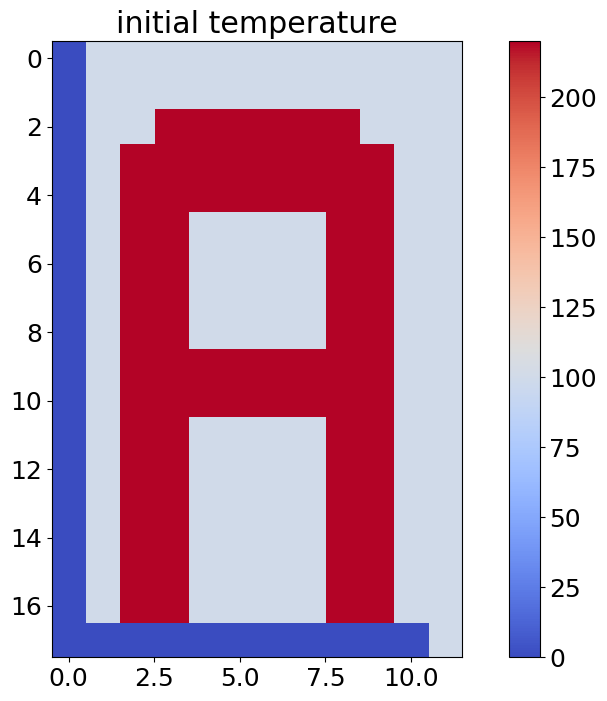

--最終結果--
ピクセル数：12×18
収束判定: True
計算回数: 12
収束画像


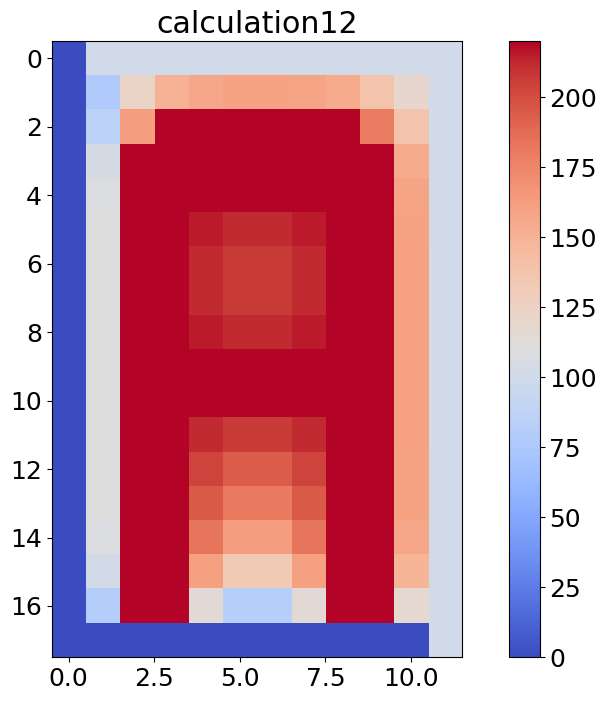

end


In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt
#import japanize_matplotlib

#ランダム
np.random.seed(0)

# 定数を生成
# 横軸の温度を生成
X_MAX = 100.0
X_MIN = 0.0

# 縦軸の温度を生成
Y_MAX = 100.0
Y_MIN = 0.0

#ランダム生成範囲:value_min <= ℃ <= value_max
value_min = 0.0
value_max = 220.0

# 材料の場所_温度[℃]
MATERIAL_LOCATION = 220.0
#収束条件[℃]
Convergence_condition = 1/100
#0.0000001:33


# 周囲に固定値を投入
def input_array(M,out_side_xmin, out_side_xmax, out_side_ymin, out_side_ymax):
    out_side_value = [out_side_xmin, out_side_xmax, out_side_ymin, out_side_ymax]
    x = 0
    y = 0
    z = 0
    x_range = len(M[0])  # X軸の長さ
    y_range = len(M)  # y軸の長さ
    # y軸移動で固定値を代入する処理
    while y < y_range:
        M[y][x] = out_side_value[z]
        y = y + 1
        if x != -1 and y == y_range:
            y = 0
            x = -1
            z = z + 1
        elif x == -1 and y == y_range:
            y = 0
            x = 1
            z = z + 1
            # x軸移動で固定値を代入する処理
            while x < x_range - 1:
                M[y][x] = out_side_value[z]
                x = x + 1
                if y != -1 and x == x_range - 1:
                    x = 1
                    y = -1
                    z = z + 1
                elif y == -1 and x == x_range - 1:
                    return M


# 二次元配列の生成
def create_2d_array(rows, columns, element):  # (y軸の個数,x軸の個数,配列内の数値)
    return [[element] * columns for _ in range(rows)]


#樹脂の有無をマーキングする
def Material_Marking(M,Mold_value):
    i = 0
    j = 0
    #横軸縦軸の数を合わせるために、同じ行列をコピー
    Mold_location =copy.deepcopy(M)
    #配列の要素内の場合:True
    while len(M) >= j and len(M[0]) >= i:

        #配列内に樹脂がある場合:Trueを代入
        if M[j][i] == Mold_value:
            Mold_location[j][i] = True
        #配列内に樹脂がない場合:Falseを代入
        else:
            Mold_location[j][i] = False
        i += 1
        #右端に付いたら左端に戻り一段下がる
        if i >= len(M[0]) - 1:
            i = 1
            j += 1
        #右下に付いたらBreak
        if  j >= len(M) - 1:
            break
    return Mold_location


# ランダム値を生成
def Array_Outer_Reference(M, y, x, start, end, threshold):
    while y != len(M):
        # 生成先に固定値がある場合
        if x == 0 and y == 0:
            x = 1
            y = 1

        # 生成先に素材がある場合
        if M[y][x] == threshold:
            x += 1
            continue
        #固定値および素材が存在しない場合
        elif x == len(M[0]):
            y += 1
            x = 1
        else:
            #ランダムな数値を入力
            #M[y][x] = np.random.randint(start, end + 1)
            #任意の値を決定
            M[y][x] = 100
            x += 1

        if x == len(M[0]) - 1:
            y += 1
            x = 1

        # 行列の右端なら処理修了
        if y >= len(M) - 1:
            break
    return M


# 温度計算
def Temp_Calculation(M, Y, X):
    if Y == 0 or X == 0:
        X = 1
        Y = 1

    # 十字計算
    a = M[Y][X + 1]
    b = M[Y][X - 1]
    c = M[Y + 1][X]
    d = M[Y - 1][X]

    # 計算結果の出力
    return (a + b + c + d) / 4


# 温度の収束判断
def Convergence_judg(M, W, j, i,Convergence_condition):
    i = 1
    j = 1
    msg = False
    # 比較する行列の大きさが異なる場合
    if len(M) != len(W) and len(M[0]) != len(W[0]):
        msg = "比較する行列の大きさが異なります"

    # 比較する行列の大きさが同じな場合
    else:
        #前回と今回の差が収束条件を満たしている場合、ループを続行
        if abs(M[j][i] - W[j][i]) < Convergence_condition:
            msg = True
            #print("True判定")
        #前回と今回の差が収束条件を満たしていない場合、ループを外れる
        elif abs(M[j][i] - W[j][i]) >= Convergence_condition:
            msg = False
            #print("False判定")
    return msg
#配列内に任意の値がどの位含まれているかを調べる
def count_values_above_threshold(array, threshold):
    count = 0
    for row in array:
        for value in row:
            if value >= threshold:
                count += 1
    return count

def ploter(M, title, xlabel='', ylabel='', figsizex=12, figsizey=8, fontsize=18, show_values=False, value_fontsize=12, value_color='white', vmin=value_min, vmax=value_max,save_fig=True):
    # NumPyの配列に変換
    data_array = np.array(M)

    # カスタムカラーマップの作成
    custom_cmap = plt.cm.get_cmap('coolwarm')

    # グラフのサイズを調整
    plt.figure(figsize=(figsizex, figsizey))
    plt.rcParams['font.size'] = fontsize

    # imshowを使ってグラフを描画し、カラーマップと範囲を設定
    plt.imshow(data_array, cmap=custom_cmap, interpolation='nearest', vmin=vmin, vmax=vmax)

    # グラフの各セルに数値を表示
    if show_values:
        for i in range(data_array.shape[0]):
            for j in range(data_array.shape[1]):
                value = data_array[i, j]
                text = "{:.2f}".format(value)  # 表示する数値の書式を指定（小数点以下2桁まで）
                plt.text(j, i, text, ha='center', va='center', color=value_color, fontsize=value_fontsize,rotation=45)

    # グラフタイトルと軸ラベル
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # カラーバーを表示
    plt.colorbar()
    if save_fig:
        # 画像を保存
        plt.savefig(str(title)+'.png')

    # グラフを表示
    plt.show()

#メイン処理
A = MATERIAL_LOCATION
original_array =[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, A, A, A, A, A, A, 0, 0, 0],
                [0, 0, A, A, A, A, A, A, A, A, 0, 0],
                [0, 0, A, A, A, A, A, A, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, A, A, A, A, A, A, 0, 0],
                [0, 0, A, A, A, A, A, A, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, A, A, 0, 0, 0, 0, A, A, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

array_record = [0]*1000
# 行列の生成
Material_Maker = copy.deepcopy(Material_Marking(original_array,MATERIAL_LOCATION))
# 外側に固定値を代入
original_array = input_array(original_array, X_MIN, X_MAX, Y_MAX, Y_MIN)

# ランダム値を生成
original_array = (Array_Outer_Reference(original_array, 0, 0, value_min, value_max, MATERIAL_LOCATION))
dummy_array = copy.deepcopy(original_array)
array = copy.deepcopy(original_array)
#比較用の計算前のグラフを出力
print("計算前")
ploter(original_array,'initial temperature', vmin=value_min, vmax=value_max,save_fig=False)

i = 0
j = 0
msg = False
loop_count = 0
#loop_num = (len(array)-1)*(len(array[0])-1)*50*2
loop_num = 0
test_flg = 0
test_count = 0
judg_count = 0
c = 0

#メインループ
# 行が端に達していない場合
while msg != True:#loop_count < loop_num :#
    loop_count += 1
    # 配列の外側が参照される場合
    if i == 0 or j == 0:
        i = 1
        j = 1
    # 素材を参照した場合とばす
    if Material_Maker[j][i]:
        i += 1
        continue
    # ダミーに計算結果を代入
    while j < len(array)-1:
        # 素材を参照した場合とばす
        if Material_Maker[j][i]:
            i += 1
            continue
        #温度計算
        dummy_array[j][i] = copy.deepcopy((Temp_Calculation(array, j, i)))

        i += 1
        # 行の端に達した場合、行を折り返し列をともに+1する。
        if i >= len(array[0])-1:
            i = 1
            j += 1
            test_flg = 1

    # 列の最後かつ、行の最後の場合
    if msg != True:
        #loop_count += 1
        array_record[loop_count-1] = dummy_array
        #ploter(dummy_array,'calculation'+str(loop_count),save_fig=False)
        # ダミーともとの行列を比較、収束ならTrue
        msg = Convergence_judg(array, dummy_array,j,i,Convergence_condition)
        if msg == True:
            # 三次元配列を作成して、二次元配列を格納
            array_record[loop_count] = np.array([dummy_array])
            array = copy.deepcopy(dummy_array)
            i = 1
            j = 1
            test_flg = 0
            #array_record[loop_count-1] = dummy_array
            break
        elif msg != True:
            array = copy.deepcopy(dummy_array)
            i = 1
            j = 1
            test_flg = 0

print("--最終結果--")
print("ピクセル数："+ str(len(dummy_array[0])) + '×' + str(len(dummy_array)))
print("収束判定:",msg)
print("計算回数:",loop_count)
print("収束画像")
ploter(dummy_array,'calculation'+str(loop_count),save_fig=True)

print("end")


<ipython-input-33-2008d17db54b>:175: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  custom_cmap = plt.cm.get_cmap('coolwarm')


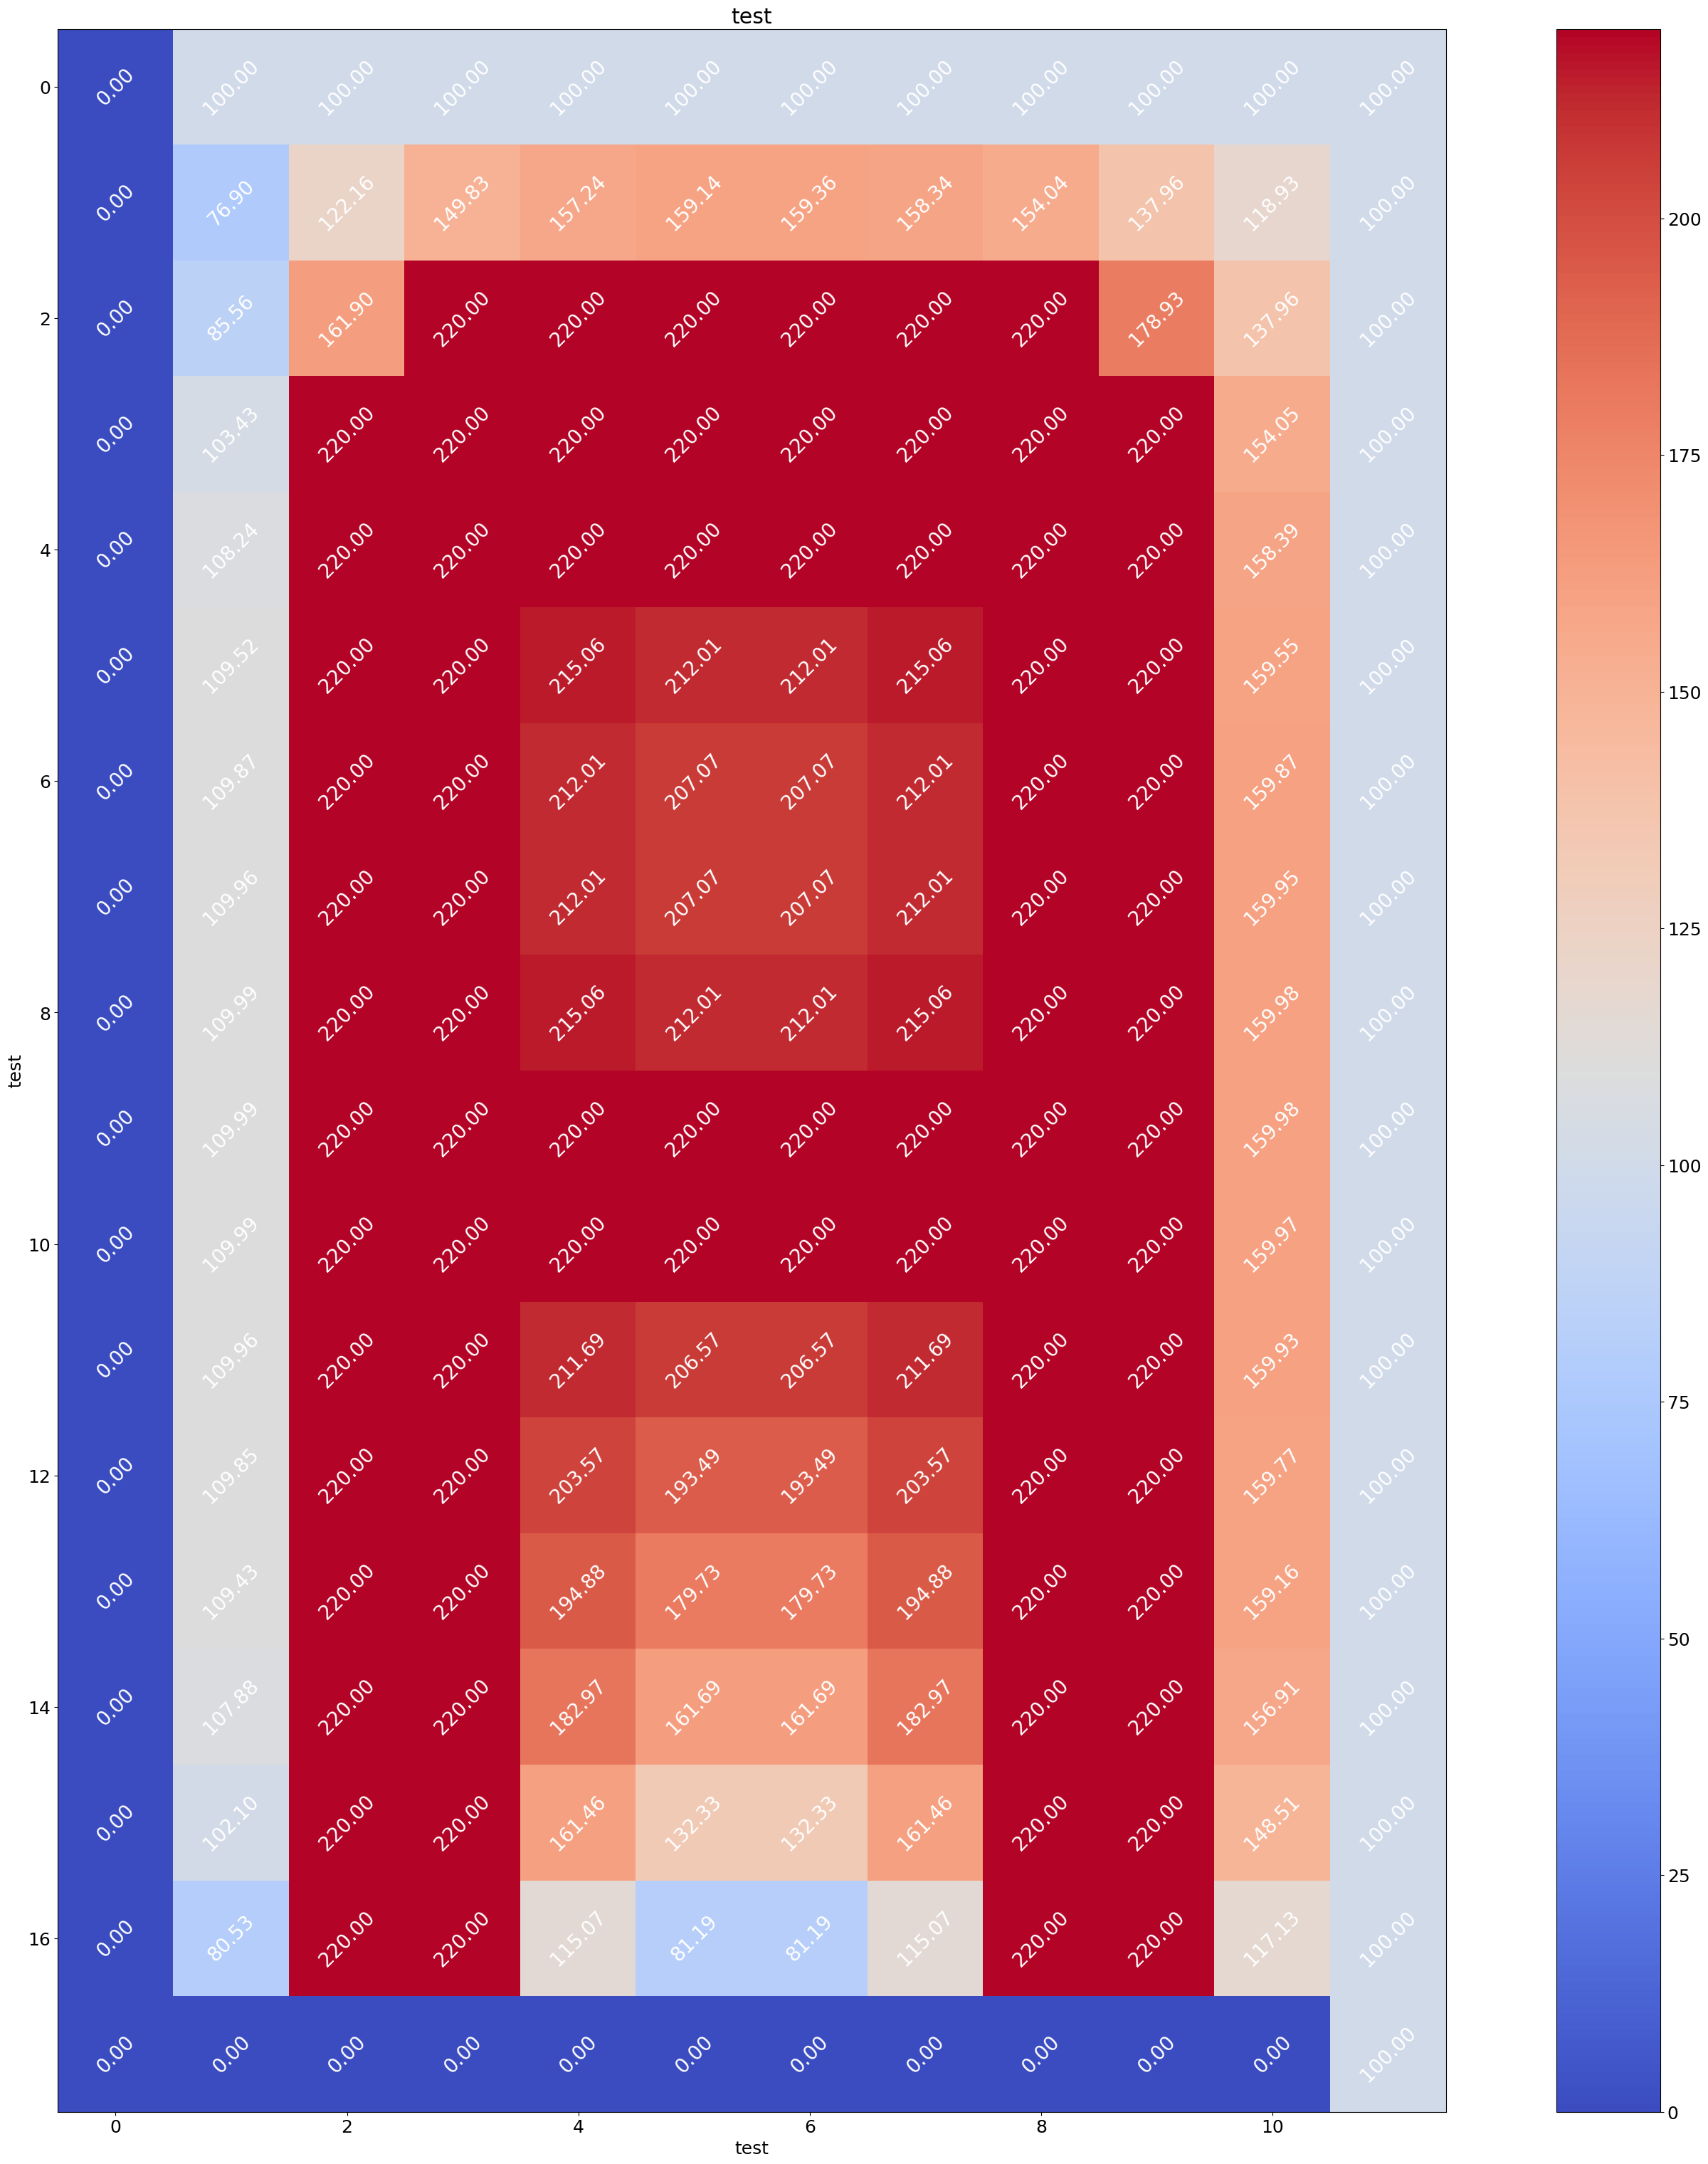

In [ ]:
tester = abs(np.array(array_record[-1]) - np.array(array_record[6]))
ploter(tester,'test', xlabel='test', ylabel='test', figsizex=40, figsizey=38, fontsize=18, show_values=True, value_fontsize=20, value_color='white', vmin=value_min, vmax=value_max,save_fig=False)